# Pronóstico serie COVID-19 en las 5 ciudades principales

**Autores:**

- Angie Melissa Calderon Albarracin
- Diego Alejandro Zapata alcaraz
- Santiago Henao Narváez
- Carlos Simon Gonzales Villamil

# Entendimiento del problema

La pandemia actual del Coronavirus y sus impactos a nivel solcio-cultural, económico, político y ambiental han llevado a las instituciones académicas, los entes gubernamentales, entes de salud a elaborar modelos para predecir su comportamiento en el futuro para tomar decisiones sobre políticas de aislamiento, económicas, etc.  

Adicional, se establecen como supuesto que las personas recuperadas adquieren inmunidad y por tanto, no hay reinfección.

##Objetivo de la oportunidad

Tomar decisiones a partir de los pronósticos realizados por los modelos seleccionados 

## Objetivo del proyecto

Realizar un modelo para pronósticar las variables asociadadas a la pandemia del COVID-19: Número de contagios por día, número de recuperado, número de muertes y partir de estas el número de contagiados activos. En las 5 ciudades de Colombia donde más contagios se han reportado 

In [409]:
# Importar liberias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from scipy.optimize import curve_fit

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# Entedimiento de los datos

## Exploración de datos

### Obtención de los datos


Se obtienen todos los datos del dataset Casos positivos de COVID-19 en Colombia, a partir del API de de la página https://www.datos.gov.co/, se incorporan en un DataFrame de Pandas y se prueba la correcta lectura de los datos mostrando la longitud del DataFrame y visualizando las 10 primeras líneas.

Dev.socrata.com. 2020. Socrata Developer Portal | Socrata. [online] Available at: <https://dev.socrata.com/foundry/www.datos.gov.co/gt2j-8ykr> .

In [2]:
pip install sodapy

In [3]:
# Forma recomendada por la fuente de los datos 
# https://dev.socrata.com/foundry/www.datos.gov.co/gt2j-8ykr

from sodapy import Socrata

client = Socrata("www.datos.gov.co",None)
results = client.get_all("gt2j-8ykr")
df = pd.DataFrame.from_records(results)
print(len(df))

658456


In [4]:
df.head()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000,PCR,11,380,Otro,NaN,NaN
1,2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09T00:00:00.000,2020-03-19T00:00:00.000,2020-03-09T00:00:00.000,PCR,76,724,Otro,NaN,NaN
2,3,2020-03-07T00:00:00.000,05001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000,PCR,5,724,Otro,NaN,NaN
3,4,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN
4,5,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN


### Limpieza de datos

Luego de revisar en forma preliminar los formatos de las columnas se define que es necesario modificar los formatos de las columnas que contienen fechas para que estos sean interpretados adecuadamente, la edad tambien debe definirse como número para validar como se comparta la pandemia según la edad.

Otra cosa que debe ajustarse es la identificación del sexo de la persona, siempre debe hacerse con una letra mayúscula para eviar inexactitudes en este rubro.

In [5]:
df.head()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000,PCR,11,380,Otro,NaN,NaN
1,2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09T00:00:00.000,2020-03-19T00:00:00.000,2020-03-09T00:00:00.000,PCR,76,724,Otro,NaN,NaN
2,3,2020-03-07T00:00:00.000,05001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000,PCR,5,724,Otro,NaN,NaN
3,4,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN
4,5,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN


In [6]:
# Cambio del tipo de datos
df['fecha_de_notificaci_n'] = pd.to_datetime(df['fecha_de_notificaci_n'])
df['fecha_diagnostico'] = pd.to_datetime(df['fecha_diagnostico'])
df['fecha_recuperado'] = pd.to_datetime(df['fecha_recuperado'])
df['fecha_reporte_web'] = pd.to_datetime(df['fecha_reporte_web'])
df['fecha_de_muerte'] = pd.to_datetime(df['fecha_de_muerte'])
df['edad'] = pd.to_numeric(df['edad'])

In [7]:
# Unificar valores columna "sexo"
df['sexo'] = df['sexo'].str.upper()
df['sexo'].value_counts()

M    337367
F    321089
Name: sexo, dtype: int64

### Segmentación 5 ciudades principales

Para determinar las 5 ciudades de Colombia en las cuales más casos de COVID-19 se han reportado se realiza un "value conunts" para la columna del dataframe que contiene esta información.

Posteriormente se excluyen del dataframe las demás ciudades pues no serán relvantes para el análisis, de acuerdo al objetivo propuesto.

In [8]:
# Top 5 ciudades con más casos
df_c = df['ciudad_de_ubicaci_n'].value_counts().head(5)
df_c

Bogotá D.C.            223522
Medellín                50942
Cali                    38887
Barranquilla            36611
Cartagena de Indias     20815
Name: ciudad_de_ubicaci_n, dtype: int64

In [9]:
# Segmentar DataFrame con las 5 ciudades principales
df = df[df['ciudad_de_ubicaci_n'].isin(['Bogotá D.C.','Medellín','Barranquilla', 'Cali', 'Cartagena de Indias'])]
df.shape

(370777, 21)

## Análisis exploratorio

### Análisis de tendencia de contagios, recuperados y muertes

Para iniciar el análisis exploratorio se comienza analizando la tendencia actual de las variables que detemerinan la evolución de la pandemia (contagios, recuperados y muertes).

#### Contagios

La curva del número total de contagios muestra la tendencia creciente de la pandemia, entre más empinada sea la curva más rápido se estará propagando la enfermedad.

In [ ]:
# Número contagios acumulado
data_cum = df.groupby(['fecha_reporte_web']).size().cumsum().reset_index()
data_cum.columns = ['Fecha','Contagios']
data_cum

,Fecha,Contagios
0,2020-03-06,1
1,2020-03-09,2
2,2020-03-11,7
3,2020-03-12,9
4,2020-03-13,11
...,...,...
175,2020-08-31,352025
176,2020-09-01,355781
177,2020-09-02,360023
178,2020-09-03,363764


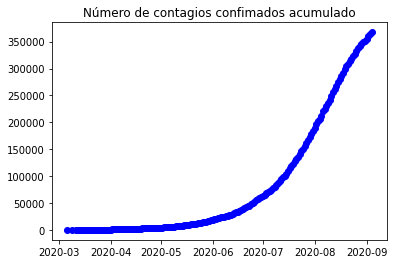

<Figure size 1080x1800 with 0 Axes>

In [ ]:
plt.plot_date(x=data_cum['Fecha'], y=data_cum['Contagios'], c='blue')
plt.title('Número de contagios confimados acumulado')
plt.figure(figsize=(15,25))
plt.show()

El número de contagios por día permite apreciar como evoluciona la pandemia día a día, este dato también es fundamental para validar que las medidas presidenciales estén reduciendo la velocidad de crecimiento de la pandemia.

En este caso puede apreciarse como la curva comienza a tomar la forma de campana característica de las pandemias.

In [ ]:
# Número contagios diario
data_c = df.groupby(['fecha_reporte_web']).size().reset_index()
data_c.columns = ['Fecha','Contagios']
data_c

,Fecha,Contagios
0,2020-03-06,1
1,2020-03-09,1
2,2020-03-11,5
3,2020-03-12,2
4,2020-03-13,2
...,...,...
175,2020-08-31,3425
176,2020-09-01,3756
177,2020-09-02,4242
178,2020-09-03,3741


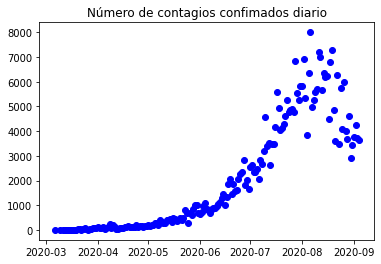

<Figure size 1080x1800 with 0 Axes>

In [ ]:
plt.plot_date(x=data_c['Fecha'], y=data_c['Contagios'], c='blue')
plt.title('Número de contagios confimados diario')
plt.figure(figsize=(15,25))
plt.show()

La descomposición de la serie de contagios por día permite apreciar los componentes de tendecia y estacionalidad, en este caso por observación de la serie original puede deducirse que no hay componente estacional observable a simple vista, en cuanto a la tendencia se observa que comienza a tener un decrecimiento. Es probable que con la flexibilisación de las medidas de aislamiento comencemos en el corto plazo un nuevo período de crecimiento en esta curva.

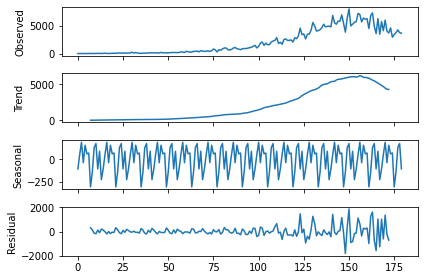

In [ ]:
# Descomposición estacional contagios diarios
descomposicion = sm.tsa.seasonal_decompose(data_c['Contagios'],model='additive', freq=14)
fig = descomposicion.plot()

#### Recuperados

Los recuperados totales tambien presentan una tendencia creciente en el tiempo. La curva de recuperados por día tambien presenta una forma de campana, no obstante esto también se ve invfluenciado por la fecha de recuperación, pues es posible que con la actualización de datos llegué días después de la fecha efectiva de recuperación.

In [ ]:
# Número de recuperados acumulado
data_r_cum = df.groupby(['fecha_recuperado']).size().cumsum().reset_index()
data_r_cum.columns = ['Fecha','Recuperados']
data_r_cum

,Fecha,Recuperados
0,2020-03-13,1
1,2020-03-14,2
2,2020-03-15,3
3,2020-03-17,4
4,2020-03-20,5
...,...,...
168,2020-08-31,266650
169,2020-09-01,273107
170,2020-09-02,278321
171,2020-09-03,281710


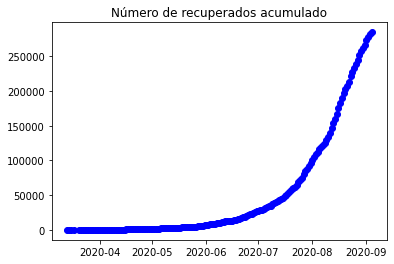

<Figure size 1080x1800 with 0 Axes>

In [ ]:
plt.plot_date(x=data_r_cum['Fecha'], y=data_r_cum['Recuperados'], c='blue')
plt.title('Número de recuperados acumulado')
plt.figure(figsize=(15,25))
plt.show()

In [ ]:
# Número de recuperados diario
data_r = df.groupby(['fecha_recuperado']).size().reset_index()
data_r.columns = ['Fecha','Recuperados']
data_r

,Fecha,Recuperados
0,2020-03-13,1
1,2020-03-14,1
2,2020-03-15,1
3,2020-03-17,1
4,2020-03-20,1
...,...,...
168,2020-08-31,4077
169,2020-09-01,6457
170,2020-09-02,5214
171,2020-09-03,3389


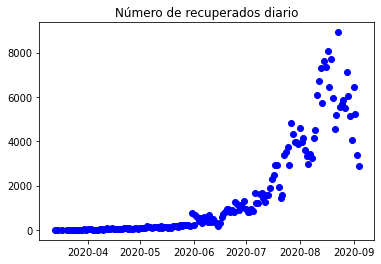

<Figure size 1080x1800 with 0 Axes>

In [ ]:
plt.plot_date(x=data_r['Fecha'], y=data_r['Recuperados'], c='blue')
plt.title('Número de recuperados diario')
plt.figure(figsize=(15,25))
plt.show()

#### Muertes

En las muertes también se presenta un comportamiento similar a las dos variables explicadas previamente.

In [ ]:
# Número de muertos confirmados acumulado
data_m_cum = df.groupby(['fecha_de_muerte']).size().cumsum().reset_index()
data_m_cum.columns = ['Fecha','Muertes']
data_m_cum

,Fecha,Muertes
0,2020-03-16,1
1,2020-03-25,4
2,2020-03-26,6
3,2020-03-27,7
4,2020-03-28,10
...,...,...
149,2020-08-20,9280
150,2020-08-21,9390
151,2020-08-22,9483
152,2020-08-23,9552


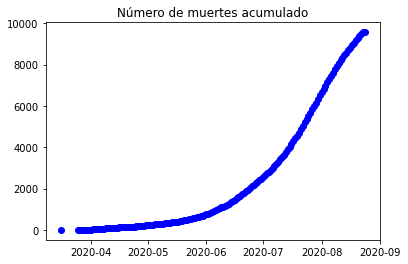

<Figure size 1080x1800 with 0 Axes>

In [ ]:
plt.plot_date(x=data_m_cum['Fecha'], y=data_m_cum['Muertes'], c='blue')
plt.title('Número de muertes acumulado')
plt.figure(figsize=(15,25))
plt.show()

In [ ]:
# Número de muertos confirmados diario
data_m = df.groupby(['fecha_de_muerte']).size().reset_index()
data_m.columns = ['Fecha','Muertes']
data_m

,Fecha,Muertes
0,2020-03-16,1
1,2020-03-25,3
2,2020-03-26,2
3,2020-03-27,1
4,2020-03-28,3
...,...,...
146,2020-08-17,99
147,2020-08-18,108
148,2020-08-19,110
149,2020-08-20,62


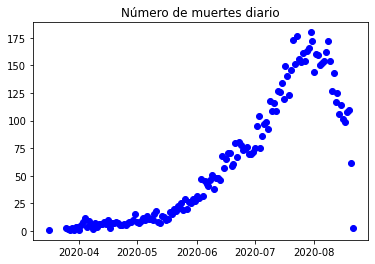

<Figure size 1080x1800 with 0 Axes>

In [ ]:
plt.plot_date(x=data_m['Fecha'], y=data_m['Muertes'], c='blue')
plt.title('Número de muertes diario')
plt.figure(figsize=(15,25))
plt.show()

In [ ]:
# Merge dataframes data_c, data_r, data_m
data = data_c.merge(data_r, on='Fecha', how='outer').merge(data_m, on='Fecha', how='outer')
data = data.melt('Fecha', var_name='Tipo', value_name='N_casos')
data

,Fecha,Tipo,N_casos
0,2020-03-06,Contagios,1.0
1,2020-03-09,Contagios,1.0
2,2020-03-11,Contagios,5.0
3,2020-03-12,Contagios,2.0
4,2020-03-13,Contagios,2.0
...,...,...,...
493,2020-08-17,Muertes,99.0
494,2020-08-18,Muertes,108.0
495,2020-08-19,Muertes,110.0
496,2020-08-20,Muertes,62.0


La siguiente gráfica muestra un comparativo para las variables contagios por día, recuperados por día y muertes por día, esta permita observar como cono el pasar del tiempo la cantidad de recuperdos supera los contagios, mientras la tasa de mortalidad es baja.

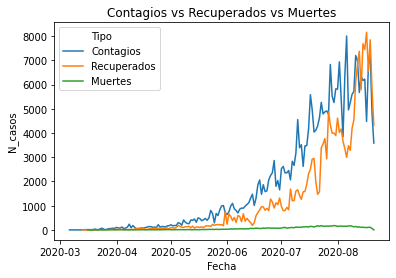

<Figure size 57600x72000 with 0 Axes>

In [ ]:
# Gráfico comparativo
sns.lineplot(x='Fecha', y='N_casos', hue='Tipo', data=data).set_title('Contagios vs Recuperados vs Muertes')
plt.figure(figsize=(800,1000))
plt.show()

### Comparación por ciudad

Por ciudad de observa que en Bogotá la cantidad de contagios por día es mucho mayor que en las demás ciudades, esto se explica debido a la catndidad de habitantes de la ciudad capital







In [ ]:
# Dataframe número de casos diarios por ciudad
data2 = df.groupby(['fecha_reporte_web', 'ciudad_de_ubicaci_n']).size().reset_index()
data2.columns = ['Fecha', 'Ciudad','N_casos']
data2

,Fecha,Ciudad,N_casos
0,2020-03-06,Bogotá D.C.,1
1,2020-03-09,Medellín,1
2,2020-03-11,Bogotá D.C.,2
3,2020-03-11,Cartagena de Indias,1
4,2020-03-11,Medellín,2
...,...,...,...
781,2020-08-22,Barranquilla,40
782,2020-08-22,Bogotá D.C.,4266
783,2020-08-22,Cali,528
784,2020-08-22,Cartagena de Indias,512


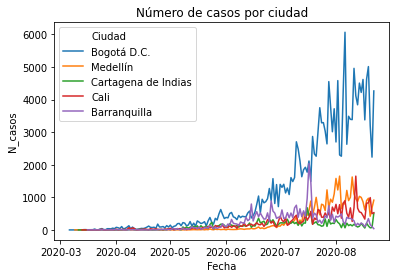

<Figure size 7200x14400 with 0 Axes>

In [ ]:
sns.lineplot(x='Fecha', y='N_casos', hue='Ciudad', data=data2).set_title('Número de casos por ciudad')
plt.figure(figsize=(100,200))
plt.show()

### Comparación por edad y género

In [ ]:
# Distribución de casos por edad y género
data3 = df.groupby(['edad', 'sexo',]).size().reset_index()
data3.columns = ['Edad', 'Sexo', 'N_casos']
data3['Edad'] = pd.to_numeric(data3['Edad'])
data3

,Edad,Sexo,Ciudad,N_casos
0,0,F,Barranquilla,65
1,0,F,Bogotá D.C.,498
2,0,F,Cali,83
3,0,F,Cartagena de Indias,53
4,0,F,Medellín,105
...,...,...,...,...
1018,104,F,Barranquilla,1
1019,104,F,Bogotá D.C.,2
1020,104,F,Medellín,1
1021,104,M,Barranquilla,1


El diagrama de cajas y Bigotes permite observar que el rango de edad donde más ocontagios ocurren es entre los 25 y 50 años, también permite observarque no hay diferencia significativa entre la media de la cantidad de casos por género

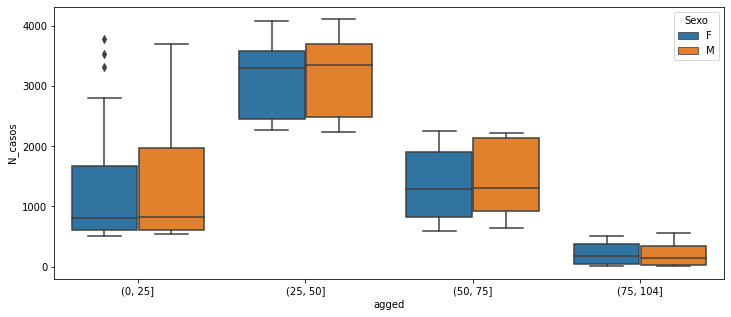

In [ ]:
# Casos por edad y género
data3["agged"] = pd.cut(data3.Edad, [0, 25, 50, 75, 104])
plt.figure(figsize=(12, 5))
sns.boxplot(x="agged", y="N_casos", hue="Sexo", data=data3)

## Evaluar variables externas

Luego de analizar múltiples artículos en donde se mencionan diferentes variables que podrían ayudar a explicar el comportamiento de la pandemia se decide evaluar la correlación de la temperatura promedio y el número de casos para una fecha dada, y también la densidad poblacional con respecto al número de casos diarios. 

In [ ]:
# Datos número de casos por ciudad
datos = df.groupby(['fecha_reporte_web', 'ciudad_de_ubicaci_n'], as_index=False).agg({'edad': ['count', 'mean']})
datos.columns = ['Fecha', 'Ciudad','Contagios', 'Edad']
datos

,Fecha,Ciudad,Contagios,Edad
0,2020-03-06,Bogotá D.C.,1,19.000000
1,2020-03-09,Medellín,1,50.000000
2,2020-03-11,Bogotá D.C.,2,25.000000
3,2020-03-11,Cartagena de Indias,1,85.000000
4,2020-03-11,Medellín,2,40.000000
...,...,...,...,...
781,2020-08-22,Barranquilla,40,43.700000
782,2020-08-22,Bogotá D.C.,4266,38.104782
783,2020-08-22,Cali,528,40.564394
784,2020-08-22,Cartagena de Indias,512,39.207031


### Temperatura por ciudad

Se utilizó el promedio diario de todas las estaciones de monitoreo de las respectivas ciudades.

Dev.socrata.com. 2020. Socrata Developer Portal | Socrata. [online] Available at: <https://dev.socrata.com/foundry/www.datos.gov.co/sbwg-7ju4>.

In [ ]:
# Importar datos de temperatura
client2 = Socrata("www.datos.gov.co",None)
results2 = client2.get_all("sbwg-7ju4", 
                           where="fechaobservacion >= '2020-03-01T00:00:00.000' AND (municipio='MEDELLÍN' OR municipio='CALI' OR municipio='BARRANQUILLA' OR municipio='CARTAGENA DE INDIAS' OR municipio='BOGOTA, D.C')")
df_temp = pd.DataFrame.from_records(results2)
print(len(df_temp))

126284


In [ ]:
df_temp.head()

,codigoestacion,codigosensor,fechaobservacion,valorobservado,nombreestacion,departamento,municipio,zonahidrografica,latitud,longitud,descripcionsensor,unidadmedida
0,1206500136,0068,2020-03-01T00:00:00.000,25.7,UNIVERSIDAD UNAD CARTAGENA - AUT,BOLIVAR,CARTAGENA DE INDIAS,CARIBE - LITORAL,10.400311111,-75.513280556,Temp Aire 2 m,°C
1,0029004520,0068,2020-03-01T00:00:00.000,25.2,ESCUELA NAVAL BARRANQUILLA - AUT,ATLANTICO,BARRANQUILLA,BAJO MAGDALENA,11.00638889,-74.785,Temp Aire 2 m,°C
2,0026085170,0068,2020-03-01T00:00:00.000,25.6,BASE AEREA MARCO FIDEL SUAREZ - AUT,VALLE DEL CAUCA,CALI,CAUCA,3.4545,-76.49972222,Temp Aire 2 m,°C
3,0021205791,0068,2020-03-01T00:00:00.000,10.7,APTO EL DORADO - TX GPRS,BOGOTA D.C.,"BOGOTA, D.C",ALTO MAGDALENA,4.706,-74.151,Temp Aire 2 m,°C
4,0021206960,0068,2020-03-01T00:00:00.000,11.5,IDEAM BOGOTA - AUT,BOGOTA,"BOGOTA, D.C",ALTO MAGDALENA,4.6,-74.06666667,Temp Aire 2 m,°C


In [ ]:
# Modificar el tipo de dato de las columnas necesárias
df_temp['fechaobservacion'] = pd.to_datetime(df_temp['fechaobservacion'])
df_temp['valorobservado'] = pd.to_numeric(df_temp['valorobservado'])

# Crear nueva columna únicamente con la fecha
df_temp['fecha'] = df_temp['fechaobservacion'].dt.date

# Nuevo df agrupado por día y ciudad, calculando el promedio de la temperatura diaria
df_t = df_temp.groupby(['fecha', 'municipio'], as_index=False)['valorobservado'].mean()

# Cambiar tipo de columna fecha a date
df_t['fecha'] = pd.to_datetime(df_t['fecha'])

# Modificar nombre de ciudades en df_t
df_t['municipio'].replace({'BARRANQUILLA': 'Barranquilla', 'BOGOTA, D.C': 'Bogotá D.C.', 'CALI': 'Cali',
                           'CARTAGENA DE INDIAS': 'Cartagena de Indias', 'MEDELLÍN': 'Medellín'}, inplace=True)

# Insertar nueva columna "key"
df_t['key'] = df_t['fecha'].astype(str) + '-' + df_t['municipio']

In [ ]:
 # Insertar nueva columna "key" a datos contagios por ciudad
datos['key'] = datos['Fecha'].astype(str) + '-' + datos['Ciudad']

In [ ]:
# Unir temperatura a Datos

datos = datos.merge(df_t, on='key', how='left').drop(['fecha', 'municipio', 'key'], axis=1)
datos.head()

In [ ]:
# Obtener media y desviación estándar de la temperatura para Cali para completar datos N/A
df_Cali = df_t[df_t['municipio']=='Cali']
prom_Cali = df_Cali['valorobservado'].mean()
std_Cali = df_Cali['valorobservado'].std()

In [ ]:
# Reemplazar valores N/A de temperatura Cali
datos['valorobservado'].fillna(prom_Cali, inplace=True)

### Densidad poblacional

La densidad poblacional es medida en número de habitantes por kilómetro cuadrado, son basados en la proyección de la población de Colombia para el 2020 según DANE.


Dev.socrata.com. 2020. Socrata Developer Portal | Socrata. [online] Available at: <https://dev.socrata.com/foundry/www.datos.gov.co/6iay-2puz>.

In [ ]:
# Importar datos de densidad poblacional
client = Socrata("www.datos.gov.co",None)
results = client.get_all("6iay-2puz")
df_den = pd.DataFrame.from_records(results)
print(len(df))

314065


In [ ]:
df_den.head()

,nombre_municipio,densidad_poblacional_por
0,Medellín,67871
125,Barranquilla,82803
150,Cartagena de Indias,18143
1005,Cali,40022


In [ ]:
# Filtrar por ciudad y columnas necesárias
df_den = df_den[df_den['nombre_municipio'].isin(['Bogotá, D.C.','Medellín','Barranquilla', 'Cali', 'Cartagena de Indias'])]
df_den = df_den.loc[:,['nombre_municipio', 'densidad_poblacional_por']]
df_den['densidad_poblacional_por'] = pd.to_numeric(df_den['densidad_poblacional_por'])

# Modificar nombre ciudades en df_den
df_den['nombre_municipio'].replace({'Bogotá, D.C.': 'Bogotá D.C.'}, inplace=True)

df_den

,nombre_municipio,densidad_poblacional_por
0,Medellín,67871
125,Barranquilla,82803
149,"Bogotá, D.C.",47791
150,Cartagena de Indias,18143
1005,Cali,40022


In [ ]:
# Unir densidad a datos

datos = datos.merge(df_den, left_on='Ciudad', right_on='nombre_municipio', how='left').drop(['nombre_municipio'], axis=1)
datos

,Fecha,Ciudad,Contagios,Edad,valorobservado,densidad_poblacional_por
0,2020-03-06,Bogotá D.C.,1,19.000000,12.265076,47791
1,2020-03-09,Medellín,1,50.000000,22.227083,67871
2,2020-03-11,Bogotá D.C.,2,25.000000,13.103898,47791
3,2020-03-11,Cartagena de Indias,1,85.000000,27.421569,18143
4,2020-03-11,Medellín,2,40.000000,19.614583,67871
...,...,...,...,...,...,...
781,2020-08-22,Barranquilla,40,43.700000,26.116667,82803
782,2020-08-22,Bogotá D.C.,4266,38.104782,10.188701,47791
783,2020-08-22,Cali,528,40.564394,23.574377,40022
784,2020-08-22,Cartagena de Indias,512,39.207031,28.280952,18143


###Análisis de correlación de variables externas

A partir del análisis de correlación se concluyó que las variables de temperatura media y densidad poblacional no aportan información significativa al modelo

In [ ]:
# Verificar la correlación de los datos
datos.corr()

,Contagios,Edad,valorobservado,densidad_poblacional_por
Contagios,1.000000,-0.049017,-0.463516,0.010719
Edad,-0.049017,1.000000,0.054808,-0.076475
valorobservado,-0.463516,0.054808,1.000000,-0.002649
densidad_poblacional_por,0.010719,-0.076475,-0.002649,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


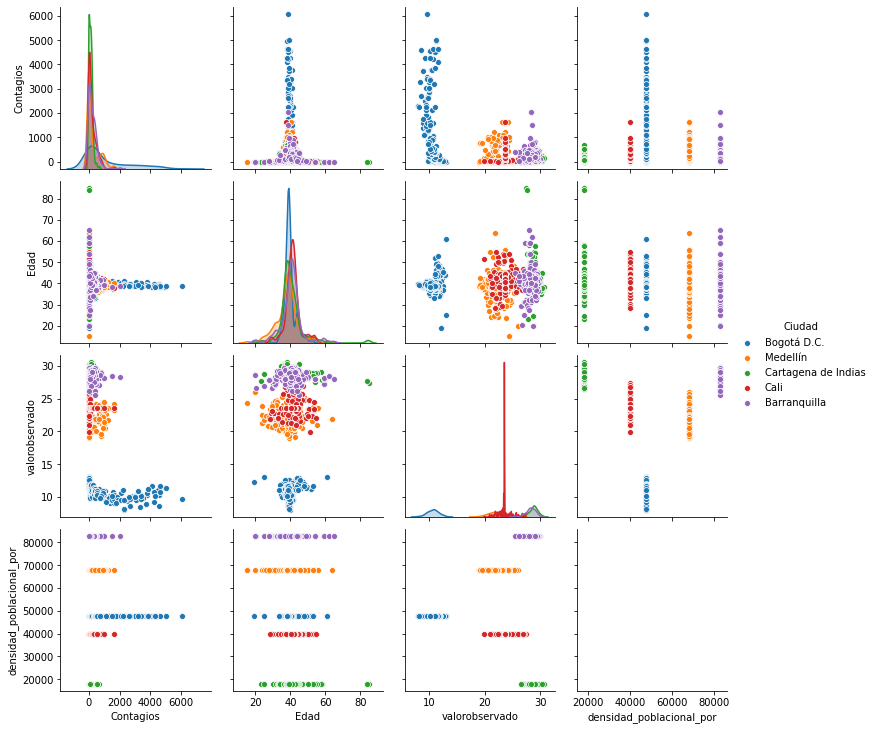

In [ ]:
sns.pairplot(datos, hue='Ciudad')

## Dataframes


A partir de los análisis anteriores se decide trabajar directamente con los datos que entrega la serie y ajustar modelos para predecir su tendencia en el corto y mediano plazo. 

Se crea un dataframe consolidado con el número de contagios, recuperados y muertes agrupados por ciudad por día (data_final), y a partir de este se genera para cada ciudad un dataframe propio para el número de casos acumulado de cada variable, y un dataframe para contagios diarios. A partir de estos se generan los dataframes para número acumulado de casos activos, estos se calculan como 'Contagios' - 'Recuperados' - 'Muertes'  para cada periodo de tiempo.


Se genera también el dataframe union, que consolida todos los anteriores.

In [10]:
# Dataframe general

# Dataframe Contagios
datos_contagios = df.groupby(['fecha_reporte_web', 'ciudad_de_ubicaci_n']).size().reset_index()
datos_contagios.columns = ['Fecha', 'Ciudad','Contagios']

# Dataframe recuperados
datos_recuperados = df.groupby(['fecha_recuperado', 'ciudad_de_ubicaci_n']).size().reset_index()
datos_recuperados.columns = ['Fecha', 'Ciudad','Recuperados']

# Dataframes muertes
datos_muertes = df.groupby(['fecha_de_muerte', 'ciudad_de_ubicaci_n']).size().reset_index()
datos_muertes.columns = ['Fecha', 'Ciudad','Muertes']
datos_muertes

# Consolidado
data_final = datos_contagios.merge(datos_recuperados, on=['Fecha', 'Ciudad'], how='left')
data_final = data_final.merge(datos_muertes,on=['Fecha', 'Ciudad'], how='left').fillna(0)

In [11]:
# Lista de ciudades
ciudades = ['Bogotá D.C.','Medellín','Barranquilla', 'Cali', 'Cartagena de Indias']

### Contagios acumulado

Los nombres de los dataframes de contagios acumulados son:

cum_Bog, cum_Med, cum_Bar, cum_Cal, cum_Car

In [12]:
# Dataframes contagios acumulado por ciudad
for i in ciudades:
  globals()['cum_'+str(i[0:3])] = data_final[data_final['Ciudad']==i].drop(['Ciudad', 'Recuperados', 'Muertes'], axis=1).reset_index()
  globals()['cum_'+str(i[0:3])]['Contagios'] = globals()['cum_'+str(i[0:3])]['Contagios'].cumsum()

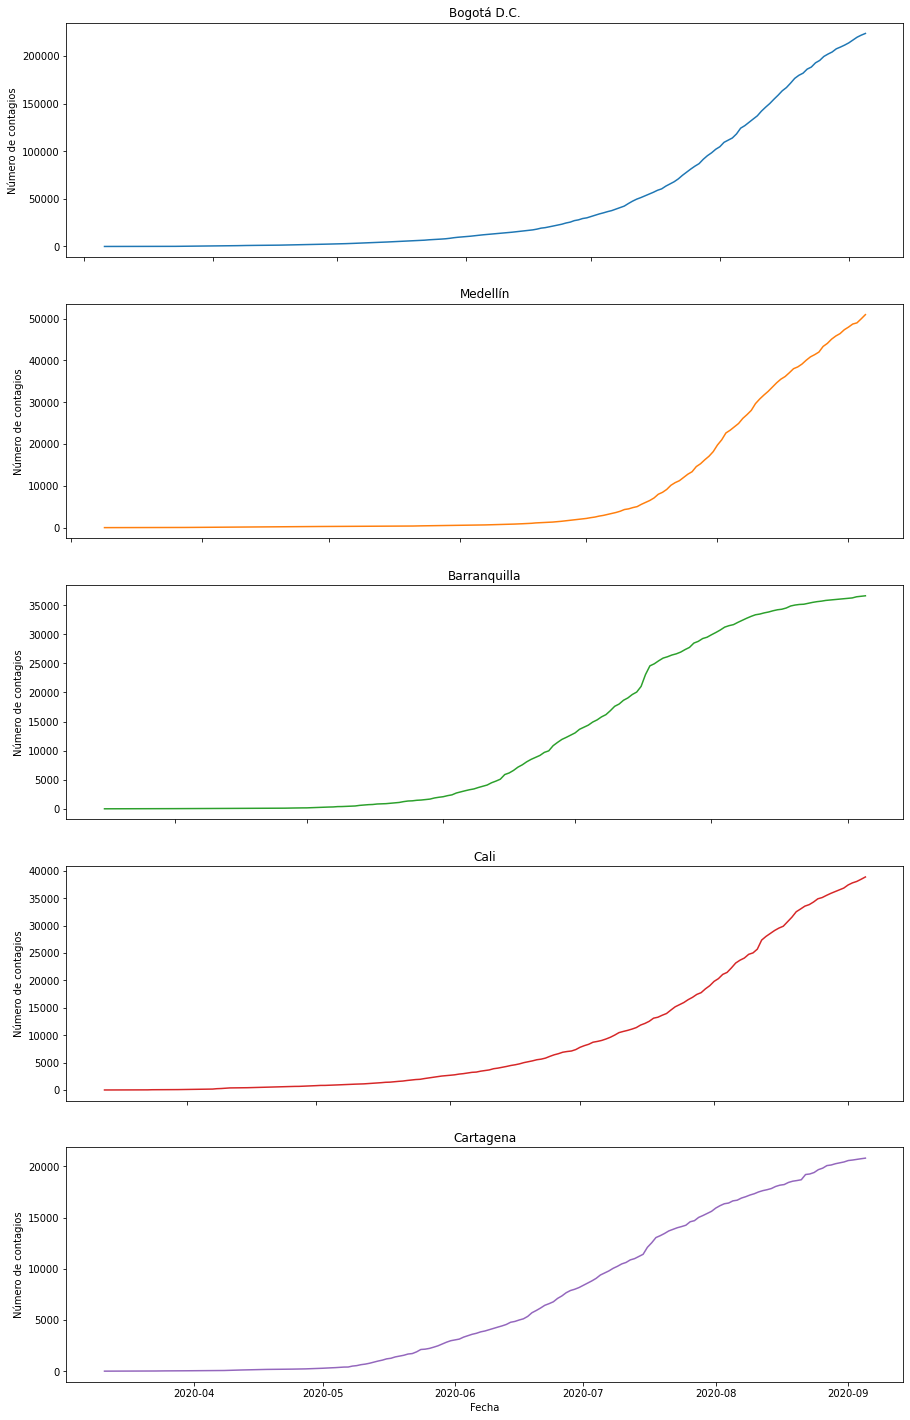

In [13]:
# Subplot comportamiento de contagios acumulado por ciudad
fig, axs = plt.subplots(5)
fig.set_size_inches(15, 25)
axs[0].plot(cum_Bog['Fecha'], cum_Bog['Contagios'])
axs[0].set_title('Bogotá D.C.')
axs[1].plot(cum_Med['Fecha'], cum_Med['Contagios'], 'tab:orange')
axs[1].set_title('Medellín')
axs[2].plot(cum_Bar['Fecha'], cum_Bar['Contagios'], 'tab:green')
axs[2].set_title('Barranquilla')
axs[3].plot(cum_Cal['Fecha'], cum_Cal['Contagios'], 'tab:red')
axs[3].set_title('Cali')
axs[4].plot(cum_Car['Fecha'], cum_Car['Contagios'], 'tab:purple')
axs[4].set_title('Cartagena')

for ax in axs.flat:
    ax.set(xlabel='Fecha', ylabel='Número de contagios')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [14]:
# DataFrames contagios diarios por ciudad por ciudad
for i in ciudades:
  globals()['c_'+str(i[0:3])] = data_final[data_final['Ciudad']==i].drop(['Ciudad', 'Recuperados', 'Muertes'], axis=1)

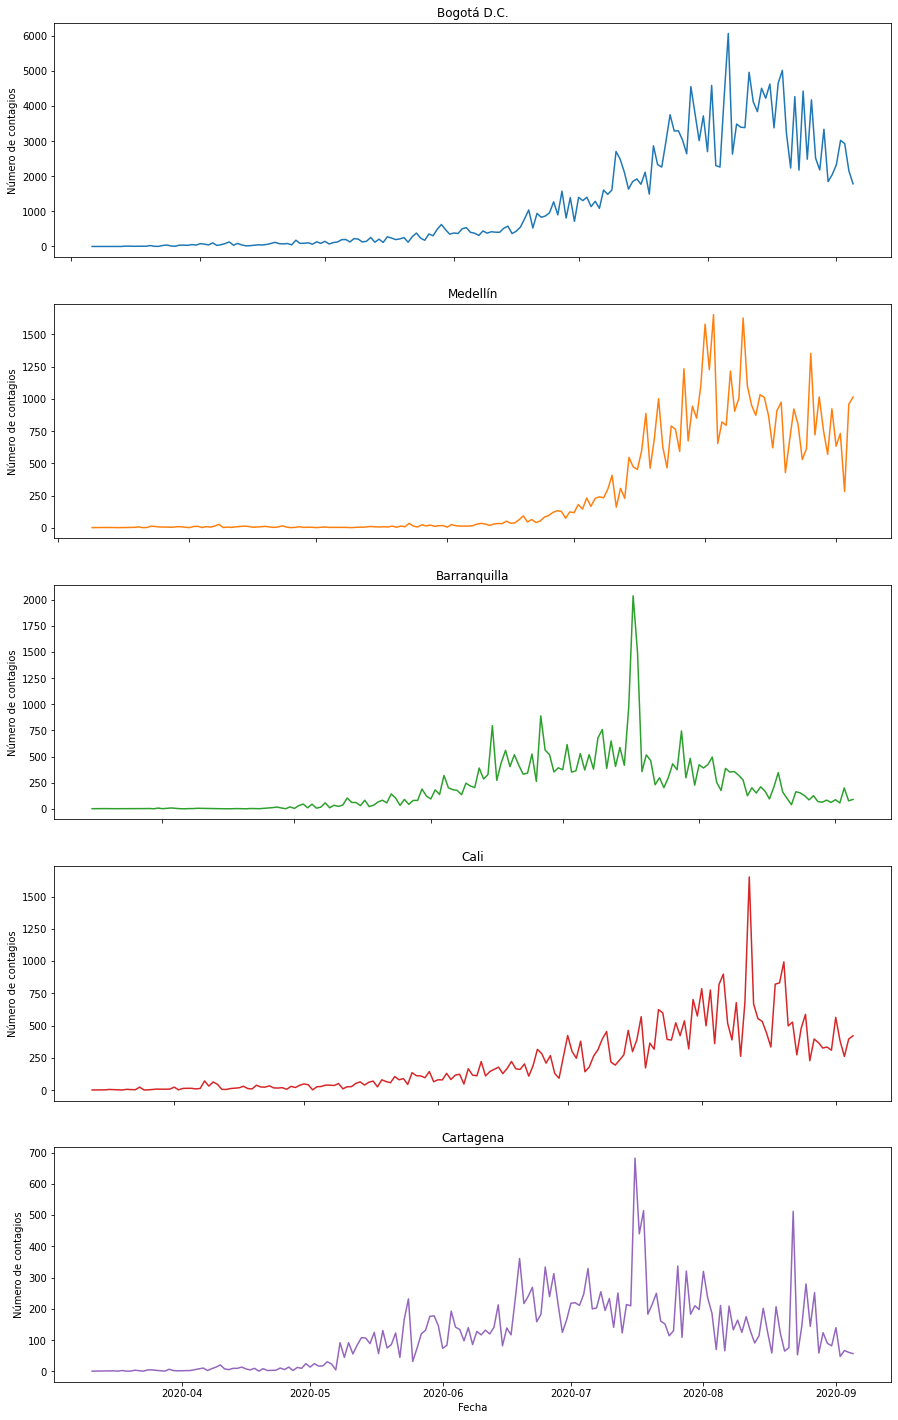

In [15]:
# Subplot comportamiento de contagios diarios por ciudad
fig, axs = plt.subplots(5)
fig.set_size_inches(15, 25)
axs[0].plot(c_Bog['Fecha'], c_Bog['Contagios'])
axs[0].set_title('Bogotá D.C.')
axs[1].plot(c_Med['Fecha'], c_Med['Contagios'], 'tab:orange')
axs[1].set_title('Medellín')
axs[2].plot(c_Bar['Fecha'], c_Bar['Contagios'], 'tab:green')
axs[2].set_title('Barranquilla')
axs[3].plot(c_Cal['Fecha'], c_Cal['Contagios'], 'tab:red')
axs[3].set_title('Cali')
axs[4].plot(c_Car['Fecha'], c_Car['Contagios'], 'tab:purple')
axs[4].set_title('Cartagena')

for ax in axs.flat:
    ax.set(xlabel='Fecha', ylabel='Número de contagios')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Contagios diarios

Los nombres de los dataframes de contagios diarios son:

c_Bog, c_Med, c_Bar, c_Cal, c_Car

In [16]:
# DataFrames contagios diarios por ciudad por ciudad
for i in ciudades:
  globals()['c_'+str(i[0:3])] = data_final[data_final['Ciudad']==i].drop(['Ciudad', 'Recuperados', 'Muertes'], axis=1)

### Recuperados

Los nombres de los dataframes de los recuperados acumulados son:

rcum_Bog, rcum_Med, rcum_Bar, rcum_Cal, rcum_Car

In [17]:
# DataFrames recuperados acumulado por ciudad
for i in ciudades:
  globals()['rcum_'+str(i[0:3])] = data_final[data_final['Ciudad']==i].drop(['Ciudad', 'Contagios', 'Muertes'], axis=1).reset_index()
  globals()['rcum_'+str(i[0:3])]['Recuperados'] = globals()['rcum_'+str(i[0:3])]['Recuperados'].cumsum()

### Muertes
Los nombres de los dataframes de las muertes acumuladas son:

mcum_Bog, mcum_Med, mcum_Bar, mcum_Cal, mcum_Car

In [18]:
# DataFrames muertes acumulado por ciudad
for i in ciudades:
  globals()['mcum_'+str(i[0:3])] = data_final[data_final['Ciudad']==i].drop(['Ciudad', 'Contagios', 'Recuperados'], axis=1).reset_index()
  globals()['mcum_'+str(i[0:3])]['Muertes'] = globals()['mcum_'+str(i[0:3])]['Muertes'].cumsum()

### Activos

acum_Bog, acum_Med, acum_Bar, acum_Cal, acum_Car

In [19]:
# DataFrames activos acumulado por ciudad
for i in ciudades:
  globals()['acum_'+str(i[0:3])] = data_final[data_final['Ciudad']==i] 
  globals()['acum_'+str(i[0:3])]['Contagios'] = globals()['acum_'+str(i[0:3])]['Contagios'].cumsum()
  globals()['acum_'+str(i[0:3])]['Recuperados'] = globals()['acum_'+str(i[0:3])]['Recuperados'].cumsum()
  globals()['acum_'+str(i[0:3])]['Muertes'] = globals()['acum_'+str(i[0:3])]['Muertes'].cumsum()
  globals()['acum_'+str(i[0:3])]['Activos'] = globals()['acum_'+str(i[0:3])]['Contagios'] - globals()['acum_'+str(i[0:3])]['Recuperados'] - globals()['acum_'+str(i[0:3])]['Muertes']  
  globals()['acum_'+str(i[0:3])] = globals()['acum_'+str(i[0:3])].drop(['Ciudad', 'Contagios', 'Recuperados', 'Muertes'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

### Union DataFrames

In [22]:
# DataFrames union
for i in ciudades:
  globals()['union_'+str(i[0:3])] = []
  globals()['union_'+str(i[0:3])] = pd.merge(pd.merge(pd.merge(pd.merge(globals()['cum_'+str(i[0:3])],globals()['acum_'+str(i[0:3])],on='Fecha'),globals()['mcum_'+str(i[0:3])],on='Fecha'),globals()['rcum_'+str(i[0:3])],on='Fecha'),globals()['c_'+str(i[0:3])],on='Fecha')
  globals()['union_'+str(i[0:3])] = globals()['union_'+str(i[0:3])].drop(columns=['index_x','index_y','index'])
  globals()['union_'+str(i[0:3])]['Ciudad'] = i

union = np.concatenate([union_Bar,union_Bog,union_Cal,union_Car,union_Med])
union = pd.DataFrame(union,columns=['Fecha','Contagios acum','Activos','Muertes','Recuperados','Contagios por dia','Ciudad'])

In [23]:
#Convertir valores a enteros
union['Contagios acum'] = pd.to_numeric(union['Contagios acum'], downcast='signed')
union['Activos'] = pd.to_numeric(union['Activos'], downcast='signed')
union['Muertes'] = pd.to_numeric(union['Muertes'], downcast='signed')
union['Recuperados'] = pd.to_numeric(union['Recuperados'], downcast='signed')
union['Contagios por dia'] = pd.to_numeric(union['Contagios por dia'], downcast='signed')

# Propuesta y evaluación de modelos

A continuación se presentan los modelos de predicción propuestos para realizar el pronóstico de la serie.

## Polinomio

Para este modelo se evaluaron diferentes grados de polinomios para las ciudades Medellín y Barranquilla, y se escogieron los mejores implementando la técnica del gradiente descendiente. Luego, se ajustaron a los datos de contagios acumulados.


Velásquez Henao, J., 2020. Material De Apoyo Para Cursos — Documentación De --- Cursos --- -. [online] Jdvelasq.github.io. Available at: <https://jdvelasq.github.io/courses/index.html> [Accessed 1 September 2020].

### Polinomio Medellín

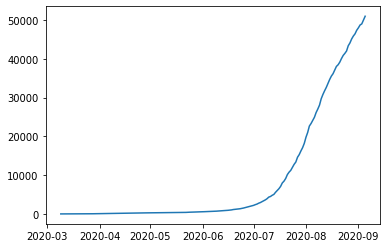

In [25]:
plt.plot(cum_Med['Fecha'], cum_Med['Contagios'])
plt.show()

In [58]:
# Convertir arreglo np
d_dataMed = cum_Med['Contagios'].values
x_dataMed = list(range(len(cum_Med.index)))
x_dataMed = np.array(x_dataMed)

Polinimio grado1 MSE fit: 81173997.50433645 MSE test: 83538732.24220565
Polinimio grado2 MSE fit: 12297531.889915673 MSE test: 12766737.717071563
Polinimio grado3 MSE fit: 2702025.008575911 MSE test: 2888453.2985060834
Polinimio grado4 MSE fit: 2523992.429881254 MSE test: 2739546.894325982
Polinimio grado5 MSE fit: 761927.2493078891 MSE test: 824336.108029159
Polinimio grado6 MSE fit: 282805.3741198094 MSE test: 326435.13904587214
Polinimio grado7 MSE fit: 272685.73652513925 MSE test: 321080.3584478711
Polinimio grado8 MSE fit: 111183.68176213837 MSE test: 127884.20757839899
Polinimio grado9 MSE fit: 49403.06521061246 MSE test: 59278.34177703333
Polinimio grado10 MSE fit: 49398.640910342925 MSE test: 61299.42586712116
Polinimio grado11 MSE fit: 35754.01029798588 MSE test: 42814.30712945152


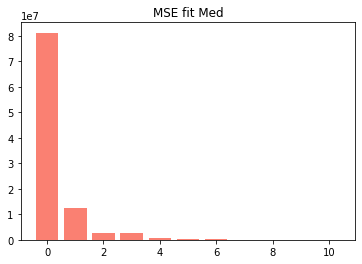

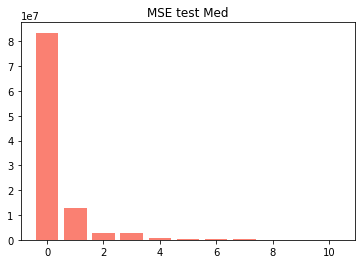

In [74]:
# Seleccionar el grado del polinomio

LOO = LeaveOneOut()

mse_fit = []
mse_test = []

for n in range(1, 12):

    # se almacenan los resultados de cada corrida en una lista
    mse_fit_n = []
    mse_test_n = []

    for fit_index, test_index in LOO.split(x_dataMed):

        # Parte los datos
        x_fit, x_test = x_dataMed[fit_index], x_dataMed[test_index]
        d_fit, d_test = d_dataMed[fit_index], d_dataMed[test_index]

        #  Ajusta el polinomio
        w = np.polyfit(x_fit, d_fit, n)
        m = np.poly1d(w)

        y_fit = m(x_fit)
        y_test = m(x_test)

        mse_fit_n.append(sum((d_fit - y_fit) ** 2) / len(d_fit))
        mse_test_n.append(sum((d_test - y_test) ** 2) / len(d_test))

    mse_fit.append(sum(mse_fit_n) / len(mse_fit_n))
    mse_test.append(sum(mse_test_n) / len(mse_test_n))

# Imprimir MSE para cada grado del polinomio
aux = list(zip(mse_fit,mse_test))
n=0
for i in aux:
  n += 1
  print('Polinimio grado' + str(n),'MSE fit:',i[0],'MSE test:',i[1])  

# Gráficar MSE fit
plt.bar(range(len(mse_fit)), mse_fit, color='salmon')
plt.title('MSE fit Med')
plt.show()

# Gráficar MSE test
plt.bar(range(len(mse_test)), mse_test, color='salmon')
plt.title('MSE test Med')
plt.show()

# Se selecciona grado 4

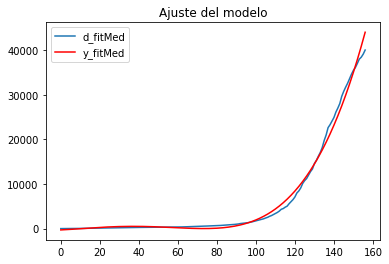

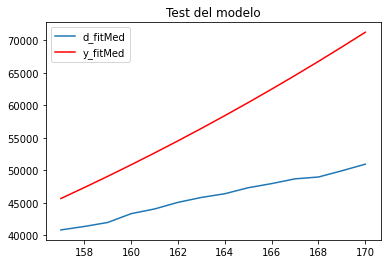

In [100]:
# Creación de datasets train y test
x_fitMed, d_fitMed = x_dataMed[0:-14], d_dataMed[0:-14]
x_testMed, d_testMed = x_dataMed[-14:], d_dataMed[-14:]

#  Ajuste del polinomio
wMed = np.polyfit(x_fitMed, y_fitMed, 4)
mMed = np.poly1d(wMed)

y_fitMed = mMed(x_fitMed)
y_testMed = mMed(x_testMed)

# Plots de ajuste
plt.plot(x_fitMed,d_fitMed)
plt.plot(x_fitMed,y_fitMed, 'r')
plt.legend(['d_fitMed', 'y_fitMed'], loc='upper left')
plt.title('Ajuste del modelo')
plt.show()

# Plots de test
plt.plot(x_testMed,d_testMed)
plt.plot(x_testMed,y_testMed, 'r')
plt.legend(['d_fitMed', 'y_fitMed'], loc='upper left')
plt.title('Test del modelo')
plt.show()

In [342]:
mse_poli_train = mean_squared_error(d_fitMed,y_fitMed)
mse_poli_test = mean_squared_error(d_testMed,y_testMed)
print('MSE train Med: '+str(mse_poli_train)+', MSE test Med: '+str(mse_poli_test))

MSE train Med: 754958.0226920177, MSE test Med: 164901692.79029942


### Polinomio Barranquilla

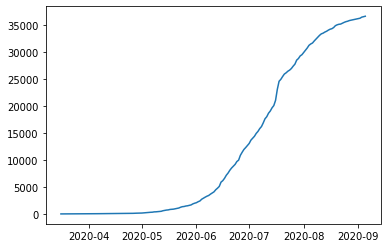

In [61]:
## Modelo Barranquilla
plt.plot(cum_Bar['Fecha'],cum_Bar['Contagios'])

In [62]:
## Ajuste del modelo
# Convertir arreglo np
d_dataBar = cum_Bar['Contagios'].values
x_dataBar = list(range(len(cum_Bar.index)))
x_dataBar = np.array(x_dataBar)

Polinimio grado1 MSE fit: 23089232.343756445 MSE test: 23669537.55696123
Polinimio grado2 MSE fit: 6744563.823878024 MSE test: 7064391.995657045
Polinimio grado3 MSE fit: 3424973.9839628097 MSE test: 3636972.6263760705
Polinimio grado4 MSE fit: 454429.2344324258 MSE test: 491509.59545745625
Polinimio grado5 MSE fit: 451247.3107484119 MSE test: 498713.9418238165
Polinimio grado6 MSE fit: 157417.36126269185 MSE test: 170267.51654098867
Polinimio grado7 MSE fit: 133414.90734582985 MSE test: 144758.0000254226
Polinimio grado8 MSE fit: 125694.40319754925 MSE test: 136718.17504896378
Polinimio grado9 MSE fit: 121314.80870167632 MSE test: 132236.9071609671
Polinimio grado10 MSE fit: 119585.31122656887 MSE test: 132071.7994776708
Polinimio grado11 MSE fit: 119304.15382649201 MSE test: 134205.4807169221


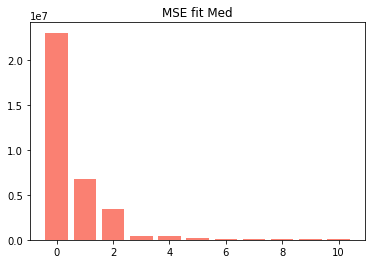

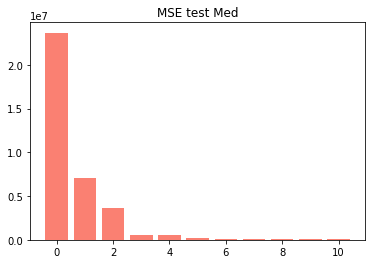

In [76]:
# Seleccionar el grado del polinomio

LOO = LeaveOneOut()

mse_fit = []
mse_test = []

for n in range(1, 12):

    # se almacenan los resultados de cada corrida en una lista
    mse_fit_n = []
    mse_test_n = []

    for fit_index, test_index in LOO.split(x_dataBar):

        # Parte los datos
        x_fit, x_test = x_dataBar[fit_index], x_dataBar[test_index]
        d_fit, d_test = d_dataBar[fit_index], d_dataBar[test_index]

        #  Ajusta el polinomio
        w = np.polyfit(x_fit, d_fit, n)
        m = np.poly1d(w)

        y_fit = m(x_fit)
        y_test = m(x_test)

        mse_fit_n.append(sum((d_fit - y_fit) ** 2) / len(d_fit))
        mse_test_n.append(sum((d_test - y_test) ** 2) / len(d_test))

    mse_fit.append(sum(mse_fit_n) / len(mse_fit_n))
    mse_test.append(sum(mse_test_n) / len(mse_test_n))

# Imprimir MSE para cada grado del polinomio
aux = list(zip(mse_fit,mse_test))
n=0
for i in aux:
  n += 1
  print('Polinimio grado' + str(n),'MSE fit:',i[0],'MSE test:',i[1])  

# Gráficar MSE fit
plt.bar(range(len(mse_fit)), mse_fit, color='salmon')
plt.title('MSE fit Bar')
plt.show()

# Gráficar MSE test
plt.bar(range(len(mse_test)), mse_test, color='salmon')
plt.title('MSE test Bar')
plt.show()

# Se selecciona grado 6

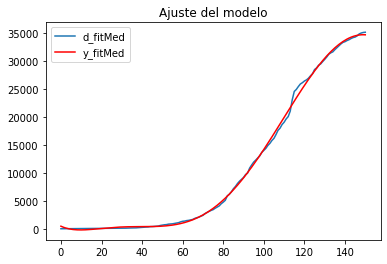

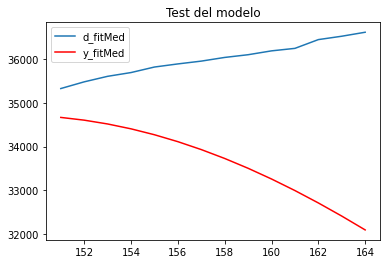

In [101]:
# Creación de datasets train y test
x_fitBar, d_fitBar = x_dataBar[0:-14], d_dataBar[0:-14]
x_testBar, d_testBar = x_dataBar[-14:], d_dataBar[-14:]

#  Ajusta el polinomio
wBar = np.polyfit(x_fitBar, d_fitBar, 6)
mBar = np.poly1d(wBar)

y_fitBar = mBar(x_fitBar)
y_testBar = mBar(x_testBar)

# Plots de ajuste
plt.plot(x_fitBar,d_fitBar)
plt.plot(x_fitBar,y_fitBar, 'r')
plt.legend(['d_fitMed', 'y_fitMed'], loc='upper left')
plt.title('Ajuste del modelo')
plt.show()

# Plots de test
plt.plot(x_testBar,d_testBar)
plt.plot(x_testBar,y_testBar, 'r')
plt.legend(['d_fitMed', 'y_fitMed'], loc='upper left')
plt.title('Test del modelo')
plt.show()

In [84]:
MSE_trainBar = mean_squared_error(d_fitBar,y_fitBar)
MSE_testBar = mean_squared_error(d_testBar,y_testBar)
print('MSE train Bar: '+str(MSE_trainBar)+', MSE test Bar: '+str(MSE_testBar))

MSE train Bar: 160026.2338908421, MSE test Bar: 6847344.601729159


## Modelo de optimización

El modelo utilizado se basa en una función exponencial que modela el comportamiento de la población infectada, por tanto, la tasa de nuevos infectados sería la derivada $(dC(t))$ de la función acumulada ($C(t)$).


Spencer, P. and Golinski, A., 2020. Modeling the Covid-19 Epidemic using Time Series Econometrics.

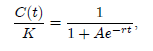

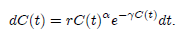

In [333]:
# Definimos la función del modelo
parametros = (2, 1, 1)

# Número de casos acumulado
def C(t,r,s):
  K = 2533424 # Población total de Medellín, proyectada para el 2020
  C0 = 2
  return (K*s)/(1+((K/C0 - 1)*np.exp(-r*t)))
  #return K/(1+((K/C0)*np.exp(-r*t)))

# Número de casos nuevos
def nuevos(t, r, a, g):
  #return C(t,r)
  return r*(C(t=t,r=r)**a)*np.exp(-g*C(t=t,r=r))

In [326]:
# Se prueba el modelo ajustando los datos de contagios acumulados de Medellín
y = cum_Med['Contagios']
# datos aleatorios para simular las observaciones
xdata = np.linspace(0, 1,len(y_Med))

In [334]:
# Optimización - ajuste del modelo para encontrar parámetros óptimos
popt_Med, pcov_Med = curve_fit(C, xdata_Med, y_Med)
# Parámetros óptimos
print(popt_Med)

[ 5.97547665 75.93608582]


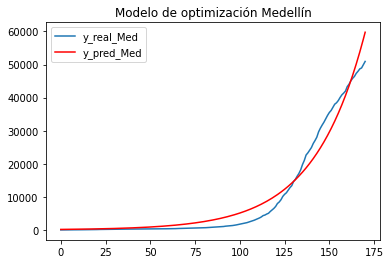

In [338]:
# Graficar comportamiento del modelo para las dos ciudades
plt.plot(y_Med)
plt.plot(C(xdata_Med, popt_Med[0], popt_Med[1]), 'r')
plt.legend(['y_real_Med', 'y_pred_Med'], loc='upper left')
plt.title('Modelo de optimización Medellín')
plt.show()

In [340]:
# Calcular error del modelo
mse_opt_Med = np.mean(keras.metrics.mean_squared_error(y, C(xdata, popt_Med[0],popt_Med[1])))
print('MSE con todos los datos: ', mse_opt_Med)

MSE con todos los datos:  7461296.723782836


## Regresión no lineal univariada con perceptrones multicapa

Este método fue aplicado para el número de contagios acumulados para Medellín. Para este caso, la regresión no converge, pues dada la tendencia creciente de la serie, el modelo no encuentra un máximo local al cual pueda acceder. Por tanto, no será considerado. Después de escalar los datos se obtuvo un modelo con el cual comparar, aún así, no logra entender los datos(alto sesgo).

Velásquez Henao, J., 2020. Material De Apoyo Para Cursos — Documentación De --- Cursos --- -. [online] Jdvelasq.github.io. Available at: https://jdvelasq.github.io/courses/index.html [Accessed 1 September 2020].

In [261]:
# Convertir serie a arreglo np
d_dataMed = cum_Med['Contagios'].values
x_dataMed = np.array(list(range(len(cum_Med.index))))

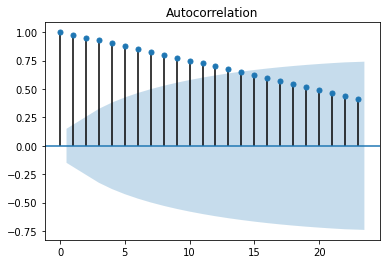

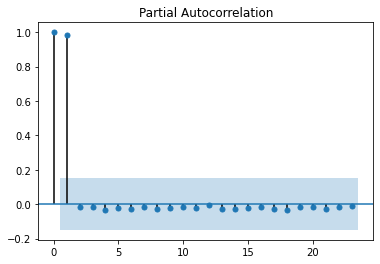

In [266]:
# Obtener ACF de la serie
plot_acf(d_dataMed)
plot_pacf(d_dataMed)
plt.show()

In [267]:
# Como primer paso se escala la serie al intervalo [0, 1]
# ya que sin este procedimiento el perceptron no converge.

scaler = MinMaxScaler()
# escalar la serie
data_scaled = scaler.fit_transform(np.array(d_dataMed).reshape(-1, 1))
# z es un array de listas como efecto del escalamiento
data_scaled = [u[0] for u in data_scaled]

In [269]:
P = 14 #Número de periodos que deja de pronosticar
Len = len(d_dataMed)
Xmed = []
for t in range(P-1, Len-1):
    Xmed.append([data_scaled[t-n] for n in range(P)])
y_scaled = data_scaled[P:]

In [271]:
# Entrenamiento del modelo
np.random.seed(123)
H = 4 # Se escoge arbitrariamente, número de células
mlpMed = MLPRegressor(
    hidden_layer_sizes=(H, ),
    activation = 'logistic',
    learning_rate = 'adaptive',
    momentum = 0.0,
    learning_rate_init = 0.1,
    max_iter = 10000)

# Entrenamiento
mlpMed.fit(
    Xmed[0:-14],  # Total menos las observaciones para Test
    y_scaled[0:-14])
# Pronostico
y_aj_scaled = mlpMed.predict(Xmed)

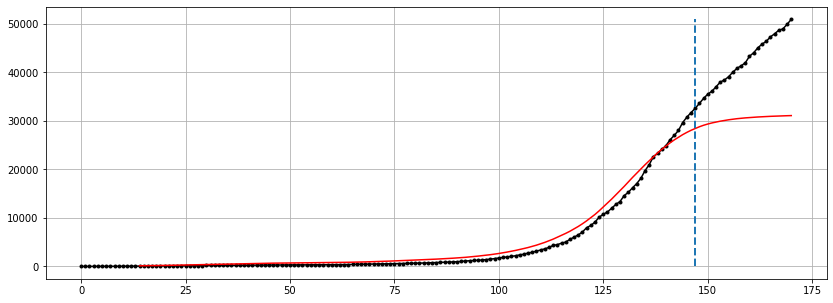

In [275]:
# Se regresa a la escala original
y_m1 = scaler.inverse_transform([[u] for u in y_aj_scaled])
y_m1 = [u[0] for u in y_m1]

plt.figure(figsize=(14,5))
plt.plot(d_dataMed, '.-k')
plt.grid()
plt.plot([None] * P + y_m1, '-r');
plt.plot([len(d_dataMed)-24, len(d_dataMed)-24], [min(d_dataMed), max(d_dataMed)], '--', linewidth=2)

In [281]:
# Métricas del modelo
# Error train
mse_perceptron_train = np.mean(keras.metrics.mean_squared_error(d_dataMed[P:-14], y_m1[:-14]))
print('MSE train: ', mse_perceptron_train)

# Error test
mse_perceptron_test = np.mean(keras.metrics.mean_squared_error(d_dataMed[-14:], y_m1[-14:]))
print('MSE test: ', mse_rnn_test)

MSE train:  4578873.99695082
MSE test:  136087220.0


## Red Neuronal Recurente RNN con LSTM

Desde el punto de vista del Deep Learning, muchos autores proponen utilizar las RNN entender las relaciones de variables indexadas en el tiempo. Ya que tiene la capacidad de procesar grandes volumnes de datos al mismo tiempo, es decir, almacena la información y la utiliza para ajustar sus pesos. 

Sin embargo, debido a los pocos datos que se tienen (porque el interes del análisis son los datos acumulado por cada día), la RNN no obtuvo la información suficiente para comprender y generalizar el comportamineto de esta pandemia.

Punn, N., Sonbhadra, S. and Agarwal, S., 2020. COVID-19 Epidemic Analysis using Machine Learning and Deep Learning Algorithms.

In [241]:
# Creamos una función para generar una matriz con el lag, para obtener los datos n pasos anteriores.
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		
    # find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		
    # gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [242]:
# Aplicación de la función utilizando contagios de Medellín
n_steps = 5
X, y = split_sequence(cum_Med['Contagios'], n_steps)

# reshape de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], 1, n_features))

# Split data

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=14, shuffle=False)

In [243]:
model = keras.Sequential()
model.add(layers.LSTM(5, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
dense_2 (Dense)              (None, 5, 1)              6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [244]:
model.compile(optimizer='adam', loss = 'mse')
historia = model.fit(xTrain, yTrain, epochs=1000, validation_split=0.2, verbose=0)
print(historia.history.keys())

dict_keys(['loss', 'val_loss'])


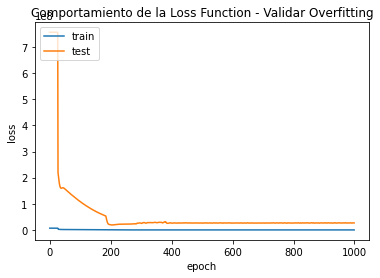

In [252]:
# Resumen del ajuste y val cruzada
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.title('Comportamiento de la Loss Function - Validar Overfitting')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [253]:
# Predicción del modelo
y_pred_nn = model.predict(X, verbose=0)
y_pred_nn = [y_pred_nn[i][-1][0] for i in range(0,len(y_pred_nn))]

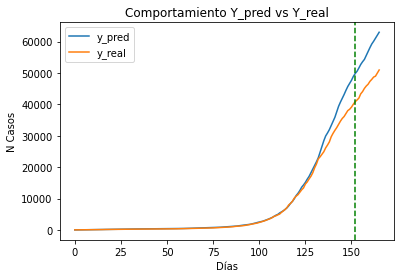

In [254]:
# Compración modelo vs real
plt.plot(y_pred_nn)
plt.plot(y.flatten())
plt.axvline(x=len(yTrain), ls='--', color='green')
plt.title('Comportamiento Y_pred vs Y_real')
plt.ylabel('N Casos')
plt.xlabel('Días')
plt.legend(['y_pred', 'y_real'], loc='upper left')
plt.show()

In [256]:
# Métricas del modelo
# Error train
mse_rnn_train = np.mean(keras.metrics.mean_squared_error(yTrain, y_pred_nn[:-14]))
print('MSE train: ', mse_rnn_train)

# Error test
mse_rnn_test = np.mean(keras.metrics.mean_squared_error(yTest, y_pred_nn[-14:]))
print('MSE test: ', mse_rnn_test)

MSE train:  279645630.0
MSE test:  136087220.0


## ARIMA

Se implementa un modelo ARIMA para pronósticar la serie para cada ciudad.

### Serie diferenciada

Una posible alternativa para modelar esta serie de tiempo como un proceso ARIMA, es diferenciando en d periodos con el objetivo de eliminar la estacionalidad y la tendencia.

Sin embargo, esta serie no muestra un patrón estacional, por tanto, no se obtiene ningun beneficio de este proceso, así se decidió utilizar la serie original.


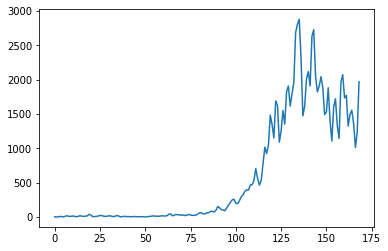

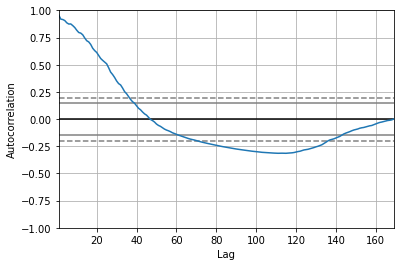

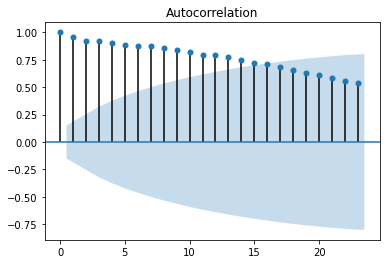

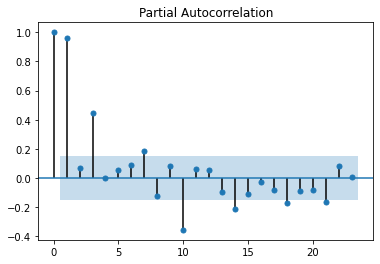

In [259]:
prueba = np.array(cum_Med['Contagios'])
# Función para diferenciar
def diferencia_d(serie,d):
  aux = pd.Series(serie).shift(d)
  return (serie-aux).dropna()

a = np.array(diferencia_d(prueba, 2))
plt.plot(a)
plt.show()

pd.plotting.autocorrelation_plot(a)
plot_acf(a)
plot_pacf(a)
plt.show()

In [ ]:
# Función inversa para extrapolar, es decir, que la serie_real se le agreguen los datos pronosticados
def inversa_diferencia_d(serie_pred, serie_real, d):
  n = len(serie_pred)
  serie_real = serie_real.tolist()
  aux = []
  for i in range(0,n):
    aux.append(serie_real[-d] + serie_pred[i])
    serie_real.append(aux[-1])
  return aux

### Grados del ARIMA (p,d,q)

Se evaluan los datos de contagios acumulados para cada ciudad para determinar cuál es la combinación de parámetros (p,d,q) óptimos para ajustar el modelo ARIMA a cada una de ellas, evaluando el criterio AIC.

Es importante aclarar que en algunos casos no se escogieron los parámetros estrictamente con el menor AIC pues se prefiere la parsimonia del modelo.

In [193]:
# Función para determinar los grados del ARIMA
def pdq_optimos(serie, num_param):
  import itertools
  p=q = range(0,num_param)
  d = range(1,3)
  pdq = list(itertools.product(p,d,q))
  vect = []
  result = [0,1000000000]
  for param in pdq:
    try:
      model_arima = ARIMA(serie,order=param)
      model_arima_fit = model_arima.fit(disp=False)
      if result[1] > model_arima_fit.aic:
        result = [param,model_arima_fit.aic]
      vect.append(result)
    except:
      continue
  return result, vect

#### Barranquilla

In [ ]:
prueba = np.array(cum_Bar['Contagios'])

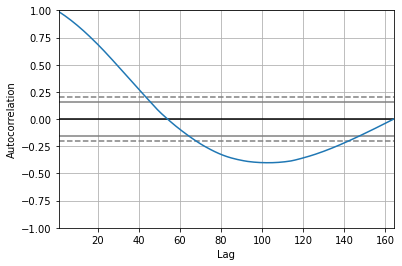

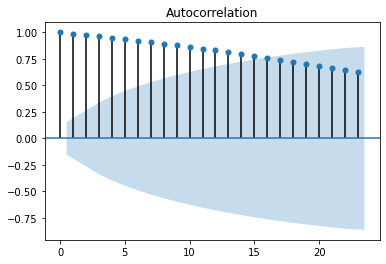

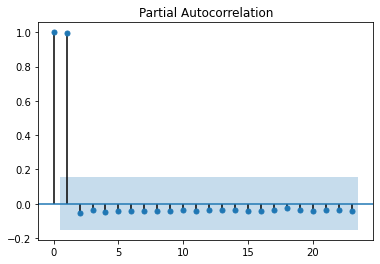

In [ ]:
# Identificación del parámetro AR(p) y MA(q)
pd.plotting.autocorrelation_plot(prueba)
plot_acf(prueba)
plot_pacf(prueba)
plt.show()

In [ ]:
r = pdq_optimos(prueba,10)
r

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: 

([(5, 2, 3), 2135.6797635760468],
 [[(0, 1, 0), 2295.0584009559275],
  [(0, 1, 1), 2213.071306109778],
  [(0, 1, 2), 2193.960624577767],
  [(0, 1, 3), 2182.707576282105],
  [(0, 1, 4), 2177.8792967069635],
  [(0, 1, 5), 2175.4809394898443],
  [(0, 1, 6), 2174.039713470878],
  [(0, 1, 6), 2174.039713470878],
  [(0, 1, 8), 2174.0265074091367],
  [(0, 1, 9), 2171.7241638772666],
  [(0, 2, 0), 2167.4519874742673],
  [(0, 2, 1), 2150.5956388624368],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 2, 2), 2135.891393675618],
  [(0, 

In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(0,2,2))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  162
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1063.946
Method:                       css-mle   S.D. of innovations            171.803
Date:                Sat, 05 Sep 2020   AIC                           2135.891
Time:                        23:53:37   BIC                           2148.242
Sample:                             2   HQIC                          2140.906
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6344      3.416      0.186      0.853      -6.061       7.330
ma.L1.D2.y    -0.4345      0.073     -5.981      0.000      -0.577      -0.292
ma.L2.D2.y    -0.3194      0.071     -4.498      0.0

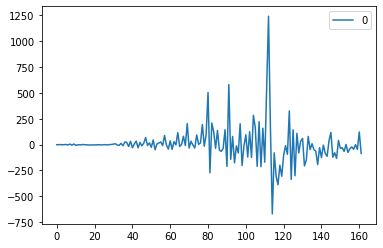

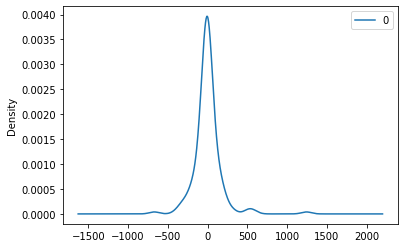

                 0
count   162.000000
mean     -0.047751
std     172.335687
min    -671.242384
25%     -46.706042
50%      -3.180745
75%      26.997943
max    1241.592399


In [ ]:
# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-14] , prueba[-14:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=(1,2,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	pred.extend(np.round(output[0]).tolist())
	historia.append(test[t])
	#print('predicted=%f, expected=%f' % (np.round(output[0]), test[t]))

mean_squared_error(test, pred)

4623.571428571428

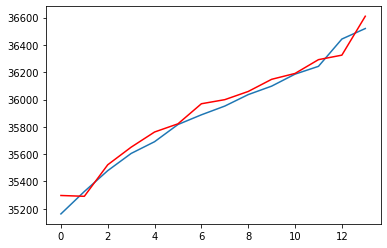

In [ ]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

#### Bogotá

In [194]:
prueba = np.array(cum_Bog['Contagios'])

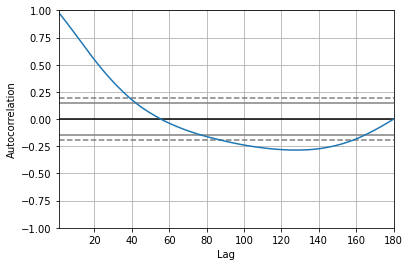

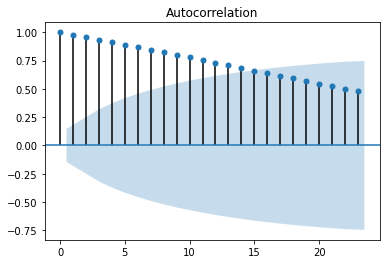

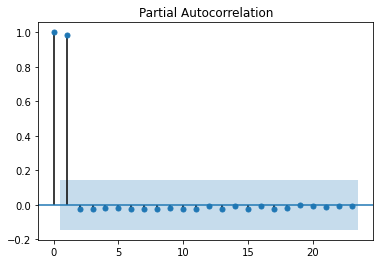

In [195]:
# Identificación del parámetro AR(p) y MA(q)
pd.plotting.autocorrelation_plot(prueba)
plot_acf(prueba)
plot_pacf(prueba)
plt.show()

In [196]:
r = pdq_optimos(prueba,10)
r

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:649: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


([(8, 2, 3), 2735.9636828175985],
 [[(0, 1, 0), 3121.8119658086357],
  [(0, 1, 1), 3009.0597387844955],
  [(0, 1, 2), 2944.7733875483227],
  [(0, 1, 3), 2915.5175286925587],
  [(0, 1, 4), 2887.132229402859],
  [(0, 1, 5), 2863.7242553389146],
  [(0, 1, 6), 2860.561648227268],
  [(0, 1, 7), 2843.554232329915],
  [(0, 1, 8), 2829.894540344098],
  [(0, 1, 9), 2817.963554690654],
  [(0, 1, 9), 2817.963554690654],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(0, 2, 1), 2744.395098806365],
  [(1, 2, 1), 2743.131626720081],
  [(1, 2, 2), 2737.398619638657],
  [(1, 2, 2), 2737.398619638657],
  [(1, 2, 2), 2737.398619638657],
  [(1, 2, 2), 2737.398619638657],
  [(1, 2, 2), 2737.398619638657],
  [(1, 2, 2), 2737.398619638657],
  [(1, 2,

In [197]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(1,2,2))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  178
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1363.699
Method:                       css-mle   S.D. of innovations            512.426
Date:                Mon, 07 Sep 2020   AIC                           2737.399
Time:                        01:41:33   BIC                           2753.308
Sample:                             2   HQIC                          2743.850
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5078     14.108      0.887      0.377     -15.143      40.158
ar.L1.D2.y     0.5971      0.170      3.512      0.001       0.264       0.930
ma.L1.D2.y    -1.5025      0.135    -11.108      0.0

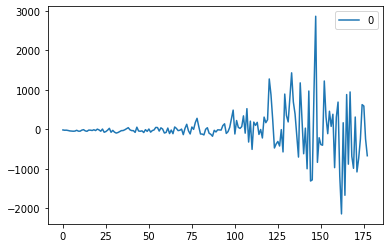

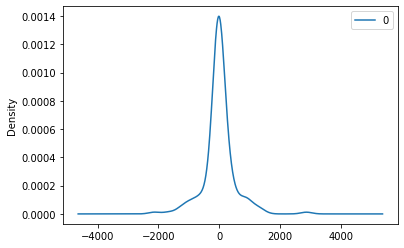

                 0
count   178.000000
mean      0.082059
std     513.873146
min   -2137.658625
25%     -93.345316
50%     -18.108631
75%      76.596277
max    2864.743123


In [198]:
# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [199]:
# Predicción del modelo
train, test = prueba[0:-14] , prueba[-14:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=(1,2,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	pred.extend(np.round(output[0]).tolist())
	historia.append(test[t])
	#print('predicted=%f, expected=%f' % (np.round(output[0]), test[t]))

mean_squared_error(test, pred)

985352.7857142857

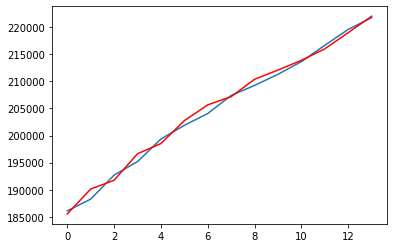

In [ ]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

#### Cali

In [ ]:
prueba = np.array(cum_Cal['Contagios'])

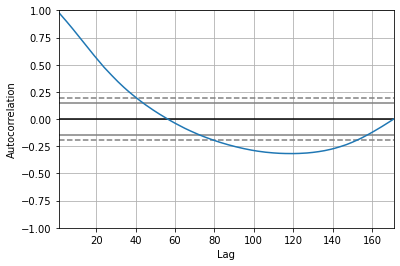

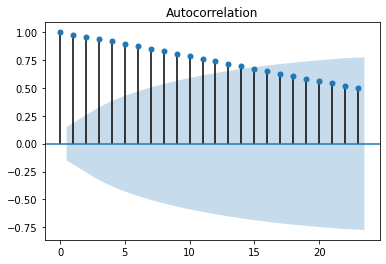

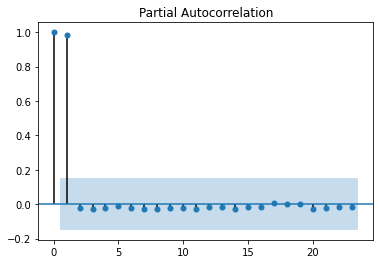

In [ ]:
# Identificación del parámetro AR(p) y MA(q)
pd.plotting.autocorrelation_plot(prueba)
plot_acf(prueba)
plot_pacf(prueba)
plt.show()

In [ ]:
r = pdq_optimos(prueba,10)
r

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsato

([(4, 2, 6), 2127.214027103657],
 [[(0, 1, 0), 2366.7867845345313],
  [(0, 1, 1), 2290.4762154746127],
  [(0, 1, 2), 2267.5534586291615],
  [(0, 1, 3), 2240.2146314866795],
  [(0, 1, 4), 2225.137848569171],
  [(0, 1, 4), 2225.137848569171],
  [(0, 1, 6), 2221.8163925058725],
  [(0, 1, 7), 2217.464401137621],
  [(0, 1, 8), 2195.749642866682],
  [(0, 1, 9), 2184.575019062113],
  [(0, 1, 9), 2184.575019062113],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(0, 2, 1), 2158.974565642518],
  [(1, 2, 3), 2142.8108644693075],
  [(1, 2, 3), 2142.8108644693075],
  [(1, 2, 3), 2142.8108644693075],
  [(1, 2, 3), 2142.8108644693075],
  [(1, 2, 3), 2142.8108644693075],
  [(1, 2, 3), 2142.8108644693075],
  [(1, 2, 3), 2142.8108644693075],
  [

In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(2,2,0))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  169
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1089.809
Method:                       css-mle   S.D. of innovations            152.712
Date:                Sun, 06 Sep 2020   AIC                           2187.618
Time:                        00:26:39   BIC                           2200.138
Sample:                             2   HQIC                          2192.699
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1073      6.490      0.325      0.746     -10.614      14.828
ar.L1.D2.y    -0.5049      0.073     -6.925      0.000      -0.648      -0.362
ar.L2.D2.y    -0.3118      0.073     -4.291      0.0

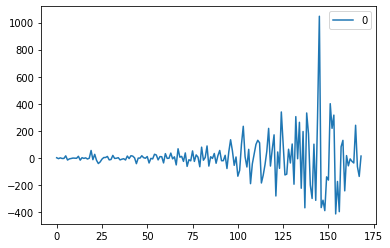

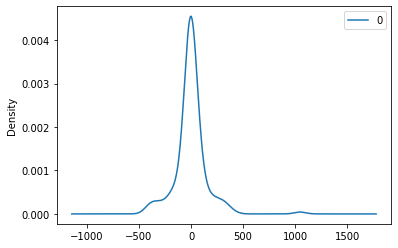

                 0
count   169.000000
mean     -0.008630
std     153.166217
min    -414.417315
25%     -37.734914
50%      -2.749211
75%      26.664941
max    1047.035950


In [ ]:
# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-14] , prueba[-14:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=(2,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	pred.extend(np.round(output[0]).tolist())
	historia.append(test[t])
	#print('predicted=%f, expected=%f' % (np.round(output[0]), test[t]))

mean_squared_error(test, pred)

27186.285714285714

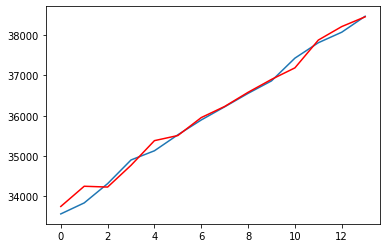

In [ ]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

#### Cartagena

In [ ]:
prueba = np.array(cum_Car['Contagios'])

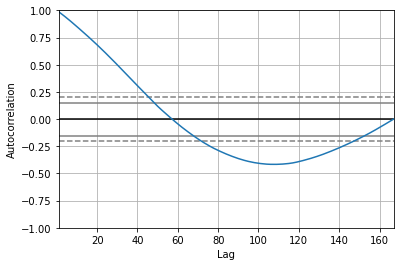

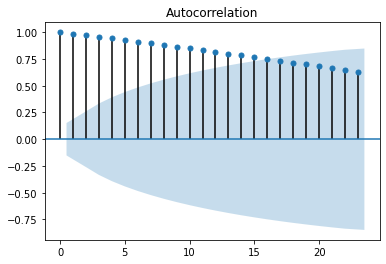

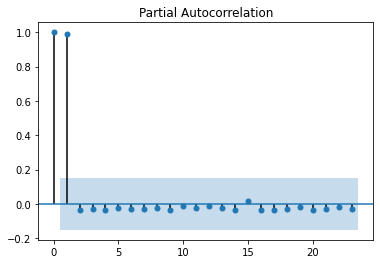

In [ ]:
# Identificación del parámetro AR(p) y MA(q)
pd.plotting.autocorrelation_plot(prueba)
plot_acf(prueba)
plot_pacf(prueba)
plt.show()

In [ ]:
r = pdq_optimos(prueba,8)
r

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invali

([(2, 2, 1), 1913.7161979560296],
 [[(0, 1, 0), 2042.4080567892906],
  [(0, 1, 1), 2004.822068057092],
  [(0, 1, 2), 1975.1277550511322],
  [(0, 1, 3), 1966.858897771828],
  [(0, 1, 4), 1959.7574298522356],
  [(0, 1, 5), 1956.5084973571647],
  [(0, 1, 6), 1956.4647389659947],
  [(0, 1, 7), 1951.1896072326977],
  [(0, 1, 7), 1951.1896072326977],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(0, 2, 1), 1913.8867337623815],
  [(2, 2, 1), 1913.7161979560296],
  [(2, 2, 1), 1913.7161979560296],
  [(2, 2, 1), 1913.7161979560296],
  [(2, 2, 1), 1913.7161979560296],
  [(2, 2, 1), 1913.7161

In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(2,2,1))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  165
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -951.858
Method:                       css-mle   S.D. of innovations             77.221
Date:                Sun, 06 Sep 2020   AIC                           1913.716
Time:                        00:30:24   BIC                           1929.246
Sample:                             2   HQIC                          1920.020
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7179      1.033      0.695      0.488      -1.306       2.742
ar.L1.D2.y     0.1039      0.091      1.143      0.255      -0.074       0.282
ar.L2.D2.y     0.1694      0.087      1.951      0.0

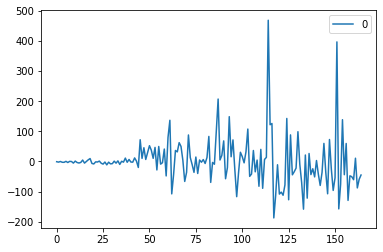

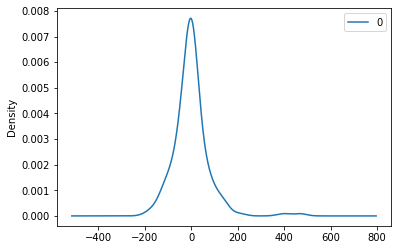

                0
count  165.000000
mean    -0.074283
std     77.455805
min   -187.142910
25%    -36.084020
50%     -2.250934
75%     15.688179
max    468.525157


In [ ]:
# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-14] , prueba[-14:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=(2,2,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	pred.extend(np.round(output[0]).tolist())
	historia.append(test[t])
	#print('predicted=%f, expected=%f' % (np.round(output[0]), test[t]))

mean_squared_error(test, pred)

19720.214285714286

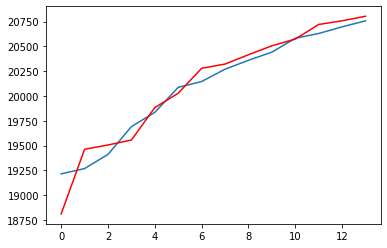

In [ ]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

#### Medellín

In [ ]:
prueba = np.array(cum_Med['Contagios'])

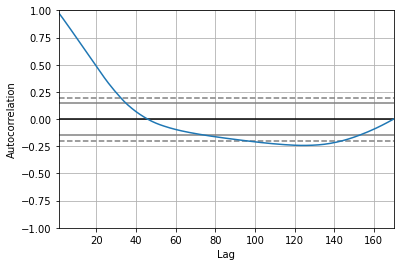

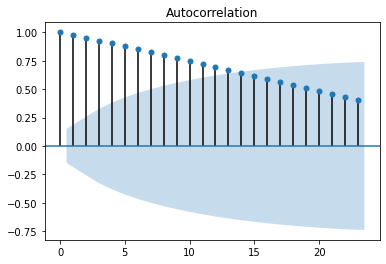

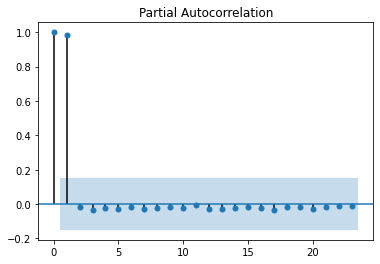

In [ ]:
# Identificación del parámetro AR(p) y MA(q)
pd.plotting.autocorrelation_plot(prueba)
plot_acf(prueba)
plot_pacf(prueba)
plt.show()

In [ ]:
r = pdq_optimos(prueba,9)
r

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: Runt

([(7, 2, 3), 2179.5878378037914],
 [[(0, 1, 0), 2519.6013893888394],
  [(0, 1, 1), 2414.5775087572024],
  [(0, 1, 2), 2359.801817522182],
  [(0, 1, 3), 2330.069731191296],
  [(0, 1, 4), 2293.2710742809554],
  [(0, 1, 5), 2287.440473764095],
  [(0, 1, 5), 2287.440473764095],
  [(0, 1, 7), 2255.8535339175346],
  [(0, 1, 7), 2255.8535339175346],
  [(0, 1, 7), 2255.8535339175346],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.9414048662375],
  [(0, 2, 1), 2195.941404

In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(0,2,1))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  168
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1094.971
Method:                       css-mle   S.D. of innovations            163.470
Date:                Sun, 06 Sep 2020   AIC                           2195.941
Time:                        00:41:43   BIC                           2205.313
Sample:                             2   HQIC                          2199.745
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3696      3.670      1.191      0.236      -2.824      11.563
ma.L1.D2.y    -0.7134      0.047    -15.265      0.000      -0.805      -0.622
                                    Roots           

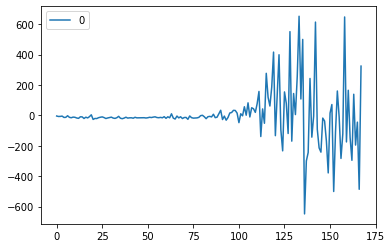

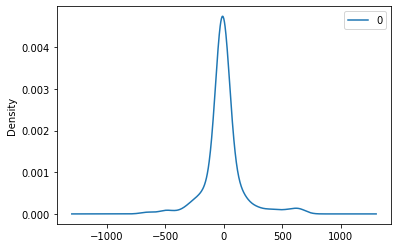

                0
count  168.000000
mean    -0.154432
std    163.958821
min   -648.162692
25%    -19.658922
50%    -13.264125
75%      5.636866
max    651.710977


In [ ]:
# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-14] , prueba[-14:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=(0,2,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	pred.extend(np.round(output[0]).tolist())
	historia.append(test[t])
	#print('predicted=%f, expected=%f' % (np.round(output[0]), test[t]))

mean_squared_error(test, pred)

82121.57142857143

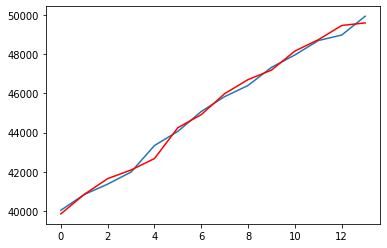

In [ ]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

### Aplicación



In [201]:
# Diccionario con valores p,d,q definidos
param = {'Bog': (1, 2, 2), 'Bar': (0, 2, 2), 'Cal': (2, 2, 0), 'Car': (2, 2, 1),'Med': (0, 2, 1)}

In [202]:
# Ajuste y pronóstico de los modelos por ciudad
# Contagios, Recuperados, Muertes

# Inicializar variables
v_poblacion = ['cum_','rcum_','mcum_']   # Nombres de dataframes recuperados, muertes, contagios
P = 1     # Número de registros utilizados para el test (Ya que se está en un punto crítico los últimos datos son relevante para el ajuste)

# Crear una lista de fechas para las cuales se van a generar los pronósticos
date = pd.to_datetime(cum_Med.loc[len(cum_Med)-1,['Fecha']])
Fecha = pd.date_range(start=date[0],periods=91,freq='D')[1:]

for j in ciudades:
  c = j[:3]   # Tomar iniciales de las ciudades
  # Crear dataframe para almacenar las predicciones, agregar Fechas
  globals()['pred_90_' + str(c)] = pd.DataFrame(Fecha, columns=['Fecha'])

  for i in v_poblacion:
    name_df = globals()[str(i)+ str(c)]      # Asignar a 'name_df' el dataframe i para la ciudad c
    prueba = np.array(name_df.iloc[:,2])     # Seleccionar columna de número de casos
    train, test = prueba[:-P], prueba[-P:]   # Crear Train y Test

    # Ajuste del modelo
    model_arima = ARIMA(train, order=(param[c]))
    model_fit_arima= model_arima.fit(disp=0)

    # Evaluar e imprimir residuales del modelo
    residuals = pd.DataFrame(model_fit_arima.resid)
    print('Media de los residuales',str(i),str(c), round(residuals.mean()[0],2))
    print('DesvStd de los residuales',str(i), str(c), round(residuals.std()[0],2))

    # Predicción del modelo
    pred_aj = np.round(model_fit_arima.predict(typ='levels'))                            # Predicción del ajuste (datos reales)
    pred = np.round(model_fit_arima.forecast(90+P)[0])                                   # Predicción 91 días adelante
    name_df['Predicción'] = [None]*param[c][1] + pred_aj.tolist() + pred[:P].tolist()    # agregar al dataframe original la columna predicción

    # Calcular e imprimir el error (MSE) del train y test
    print('MSE Train',str(i),str(c),mean_squared_error(pred_aj,train[param[c][1]:]))
    print('MSE Test',str(i),str(c),mean_squared_error(pred[:P],test),'\n')

    # Agregar a dataframe de predicciones cada columna (variable)
    globals()['pred_90_' + str(c)][i] = np.round(model_fit_arima.forecast(90+P)[0][P:])

  # Calcular y agregar al dataframe de predicciones los casos Activos y los casos por día
  globals()['pred_90_' + str(c)]['Activos'] = globals()['pred_90_' + str(c)]['cum_'] - globals()['pred_90_' + str(c)]['rcum_'] - globals()['pred_90_' + str(c)]['mcum_']
  globals()['pred_90_' + str(c)]['Contagios por dia'] = globals()['pred_90_' + str(c)]['cum_'] - globals()['pred_90_' + str(c)]['cum_'].shift(1)
  globals()['pred_90_' + str(c)]['Contagios por dia'].fillna(globals()['pred_90_' + str(c)]['cum_'][0] - globals()['cum_'+str(c)]['Contagios'][len(name_df)-1], inplace=True)
  globals()['pred_90_' + str(c)]['Ciudad'] = j
  globals()['pred_90_' + str(c)].columns = ['Fecha', 'Contagios acum', 'Recuperados', 'Muertes', 'Activos', 'Contagios por dia', 'Ciudad']
  globals()['pred_90_' + str(c)] = globals()['pred_90_' + str(c)].reindex(columns = ['Fecha', 'Contagios acum', 'Activos', 'Muertes', 'Recuperados', 'Contagios por dia', 'Ciudad'])

Media de los residuales cum_ Bog 0.05
DesvStd de los residuales cum_ Bog 512.85
MSE Train cum_ Bog 261531.32768361582
MSE Test cum_ Bog 467856.0 

Media de los residuales rcum_ Bog -0.53
DesvStd de los residuales rcum_ Bog 546.86
MSE Train rcum_ Bog 297341.29378531076
MSE Test rcum_ Bog 2350089.0 

Media de los residuales mcum_ Bog 0.01
DesvStd de los residuales mcum_ Bog 7.64
MSE Train mcum_ Bog 58.25423728813559
MSE Test mcum_ Bog 1936.0 

Media de los residuales cum_ Med -0.16
DesvStd de los residuales cum_ Med 164.03
MSE Train cum_ Med 26749.821428571428
MSE Test cum_ Med 80089.0 

Media de los residuales rcum_ Med -0.08
DesvStd de los residuales rcum_ Med 136.24
MSE Train rcum_ Med 18457.02380952381
MSE Test rcum_ Med 199809.0 

Media de los residuales mcum_ Med -0.0
DesvStd de los residuales mcum_ Med 3.31
MSE Train mcum_ Med 10.946428571428571
MSE Test mcum_ Med 100.0 

Media de los residuales cum_ Bar -0.05
DesvStd de los residuales cum_ Bar 172.34
MSE Train cum_ Bar 29531.4814

## Modelo SIR

El modelo SIR fue elegido para pronósticar el comportamiento de la pandemia a mediano plazo a partir de la literatura consultada, pues fue inicialmente concebido como un modelo epidemiológico capaz de capturar las características de los brotes de virus, y es ampliamente utilizando en este tipo de modelos, con múltiples variaciones.

El modelo SIR considera 3 tipos de individuos: Suceptibles, Infectados y Recuperados, relacionados a partir de las tasas de infección, recuperación y muerte.

El ajuste de este modelo consta de 4 partes:

1. Estimación de tasas a partir de modelos autoregresivos
2. Optimización del parametro de interacción
3. Ajuste del modelo SIR a los datos
4. Pronóstico

### Estimación de tasas a partir de modelos autoregresivos

#### Extracción de las tasas


In [344]:
#Extracción de las tasas a partir de los datos
for city in ciudades:
  tasa_cont = []
  tasa_recup = []
  tasa_muertos = []

  df_base = union[union['Ciudad'] == city].reset_index()
  for i in range(len(df_base)-1):
    tasa_cont.append(int(df_base.loc[i+1,['Contagios por dia']])/int(df_base.loc[i,['Activos']]))
    tasa_recup.append(int(df_base.loc[i+1,['Recuperados']])/int(df_base.loc[i,['Contagios acum']]))
    tasa_muertos.append(int(df_base.loc[i+1,['Muertes']])/int(df_base.loc[i,['Contagios acum']]))

  #Se ingresan valores al DF
  globals()['df_tasas_'+str(city[0:3])] = pd.DataFrame(data = tasa_cont,columns=['Tasa Contagios'])
  globals()['df_tasas_'+str(city[0:3])]['Tasa Recup'] = tasa_recup
  globals()['df_tasas_'+str(city[0:3])]['Tasa muertes'] = tasa_muertos

#### Análisis descriptivo de las tasas

En el análisis del comportamiento de las tasas, se evidencia que los primeros registros cuentan con una variabilidad significativamente más alta comparada con la de los demás datos, esto debido a la naturaleza de la serie.

Debido a esto se decide eliminar los primeros 14 registros, con el fin de ibtener un mejor ajuste.

Bogotá D.C.


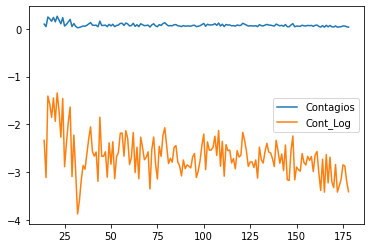

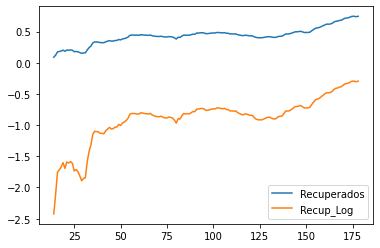

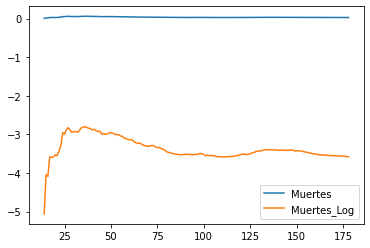

Medellín


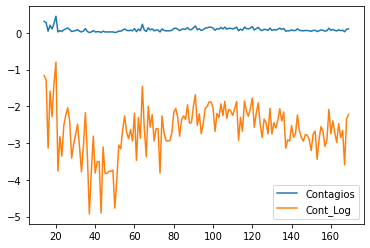

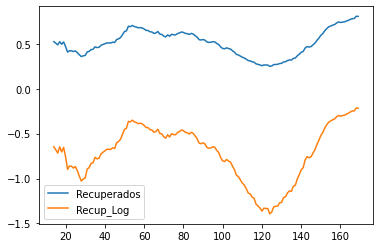

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


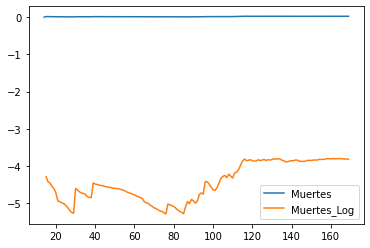

Barranquilla


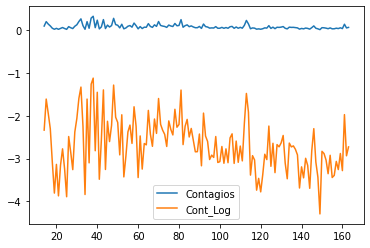

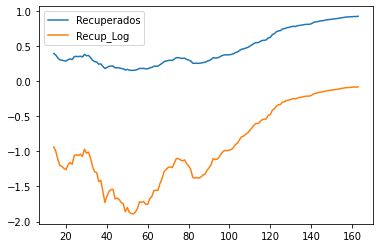

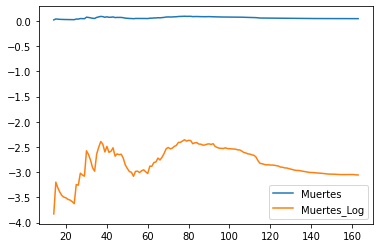

Cali


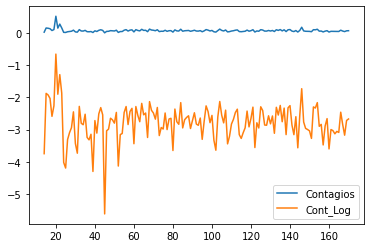

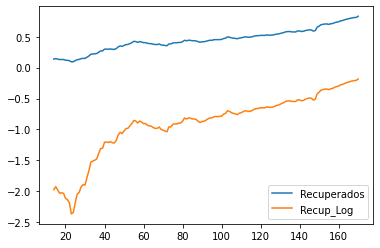

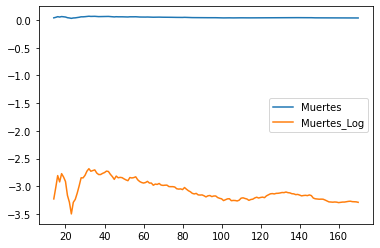

Cartagena de Indias


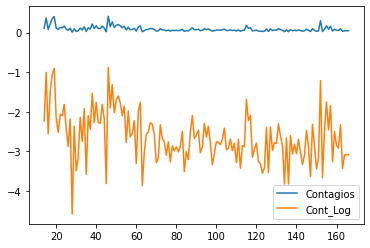

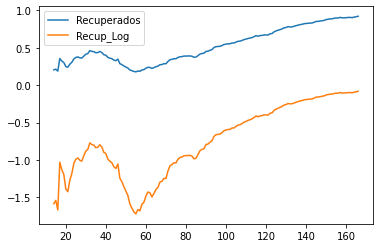

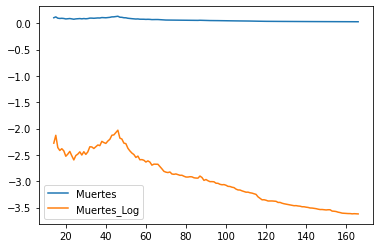

In [346]:
# Mostrando el comportamiento de las tasas y transformación Log
for city in ciudades:
  print(city)
  plt.plot(globals()['df_tasas_'+str(city[0:3])]['Tasa Contagios'][14:])
  plt.plot(np.log(globals()['df_tasas_'+str(city[0:3])]['Tasa Contagios'][14:]))
  plt.legend(['Contagios','Cont_Log'])
  plt.show()

  plt.plot(globals()['df_tasas_'+str(city[0:3])]['Tasa Recup'][14:])
  plt.plot(np.log(globals()['df_tasas_'+str(city[0:3])]['Tasa Recup'][14:]))
  plt.legend(['Recuperados','Recup_Log'])
  plt.show()

  plt.plot(globals()['df_tasas_'+str(city[0:3])]['Tasa muertes'][14:])
  plt.plot(np.log(globals()['df_tasas_'+str(city[0:3])]['Tasa muertes'][14:]))
  plt.legend(['Muertes','Muertes_Log'])
  plt.show()

In [348]:
# Función para diferenciar, para ver las tasas diferenciadas y eliminar la tendencia
def diferencia_d(serie,d=1):
  aux = pd.Series(serie).shift(d)
  return (serie-aux).dropna()

Bogotá D.C.


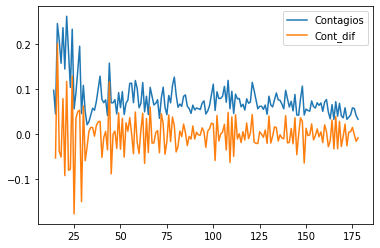

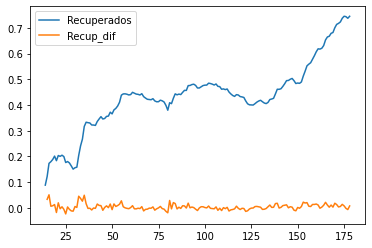

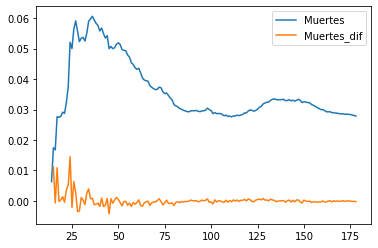

Medellín


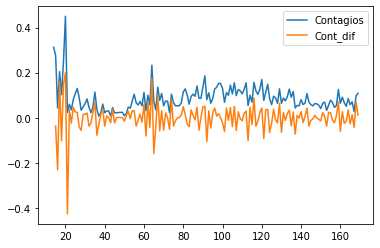

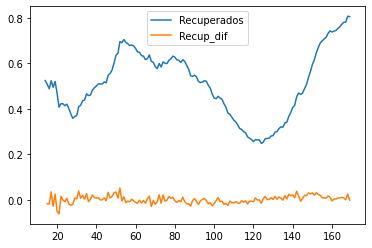

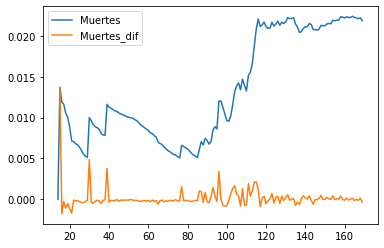

Barranquilla


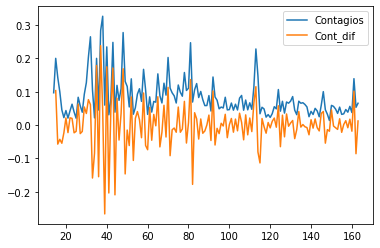

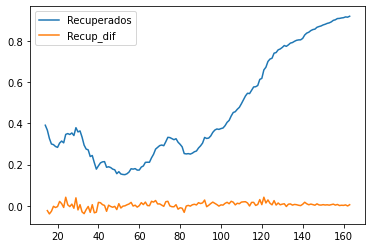

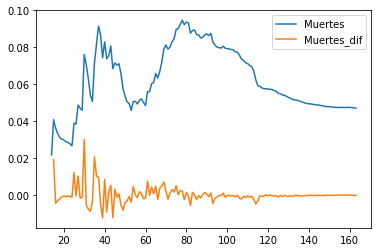

Cali


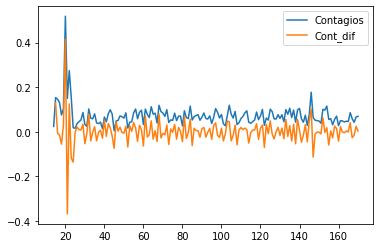

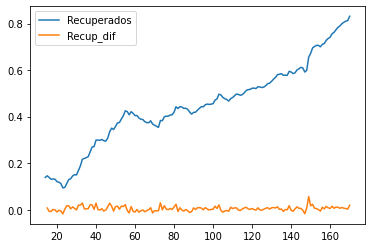

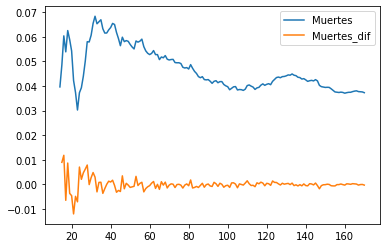

Cartagena de Indias


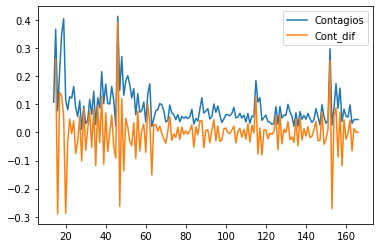

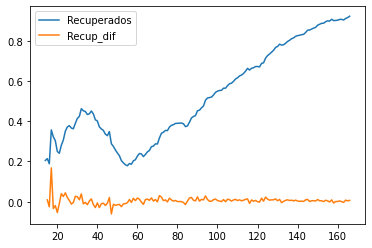

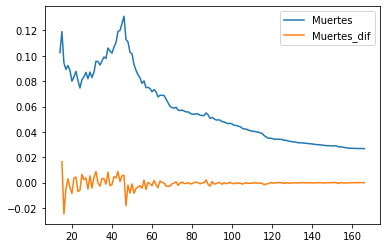

In [349]:
# Mostrando el comportamiento de las tasas y rezago
d = 1
for city in ciudades:
  print(city)

  plt.plot(globals()['df_tasas_'+str(city[0:3])]['Tasa Contagios'][14:])
  plt.plot(diferencia_d(globals()['df_tasas_'+str(city[0:3])]['Tasa Contagios'][14:],d))
  plt.legend(['Contagios','Cont_dif'])
  plt.show()

  plt.plot(globals()['df_tasas_'+str(city[0:3])]['Tasa Recup'][14:])
  plt.plot(diferencia_d(globals()['df_tasas_'+str(city[0:3])]['Tasa Recup'][14:],d))
  plt.legend(['Recuperados','Recup_dif'])
  plt.show()

  plt.plot(globals()['df_tasas_'+str(city[0:3])]['Tasa muertes'][14:])
  plt.plot(diferencia_d(globals()['df_tasas_'+str(city[0:3])]['Tasa muertes'][14:],d))
  plt.legend(['Muertes','Muertes_dif'])
  plt.show()

#### Grados del ARIMA para las tasas

Después del análisis descriptivo de las tasas (Contagios, Recuperados y Muertes), se determina que tras eliminar la tendencia, estas se pueden modelar a través de un ARIMA.

In [351]:
# Función para determinar los grados del ARIMA
def pdq_optimos(serie, num_param):
  import itertools
  p=q = range(0,num_param)
  d = range(1,3)
  pdq = list(itertools.product(p,d,q))
  vect = []
  result = [0,1000000000]
  for param in pdq:
    try:
      model_arima = ARIMA(serie,order=param)
      model_arima_fit = model_arima.fit(disp=False)
      if result[1] > model_arima_fit.aic:
        result = [param,model_arima_fit.aic]
      vect.append(result)
    except:
      continue
  return result, vect

##### Barranquilla

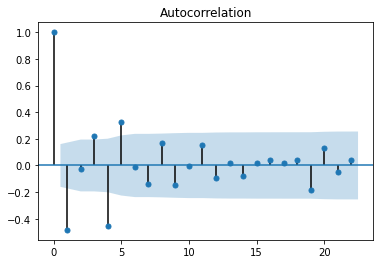

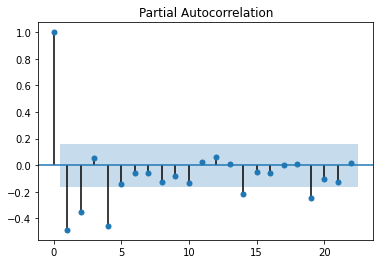

In [352]:
prueba = np.array(df_tasas_Bar['Tasa Contagios'][14:])
prueba2 = diferencia_d(df_tasas_Bar['Tasa Contagios'][14:],1)

# Identificación del parámetro AR(p) y MA(q)
plot_acf(prueba2)
plot_pacf(prueba2)
plt.show()

In [ ]:
pdq_Bar = pdq_optimos(prueba,7)

In [355]:
pdq_Bar[0]

[(5, 1, 4), -459.26189645463825]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  149
Model:                 ARIMA(5, 1, 4)   Log Likelihood                 240.631
Method:                       css-mle   S.D. of innovations              0.046
Date:                Mon, 07 Sep 2020   AIC                           -459.262
Time:                        04:44:36   BIC                           -426.218
Sample:                             1   HQIC                          -445.837
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -2.944      0.004      -0.001      -0.000
ar.L1.D.y      0.2504      0.122      2.048      0.042       0.011       0.490
ar.L2.D.y     -0.3431      0.117     -2.933      0.0

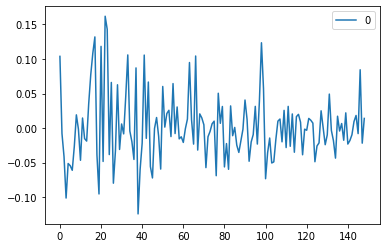

                0
count  149.000000
mean     0.001551
std      0.049060
min     -0.124158
25%     -0.025907
50%     -0.004270
75%      0.020435
max      0.161744


In [358]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=pdq_Bar[0][0])
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

In [359]:
# Predicción del modelo
train, test = prueba[0:-5] , prueba[-5:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=pdq_Bar[0][0])
	model_fit = model.fit(disp=0)
	output = model_fit.forecast(1)
	pred.extend(output[0].tolist())
	historia.append(test[t])
	print('predicted=%f, expected=%f' % (output[0], test[t]))

mean_squared_error(test, pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.039411, expected=0.056051


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.043401, expected=0.037574


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.048197, expected=0.139082


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.076356, expected=0.053140
predicted=0.051774, expected=0.065374


0.001858957525822915

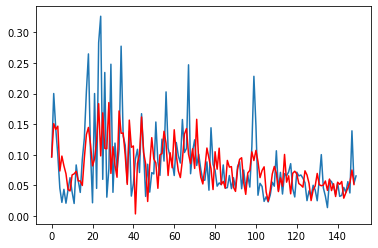

In [360]:
plt.plot(prueba)
plt.plot(model_arima_fit.predict(typ='levels'), 'r')
plt.show()

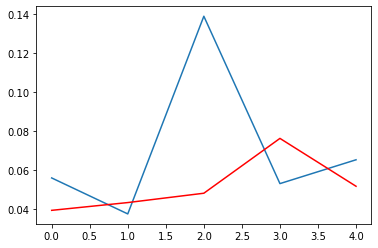

In [362]:
plt.plot(test)
plt.plot(pred, 'r')
plt.show()

##### Bogotá

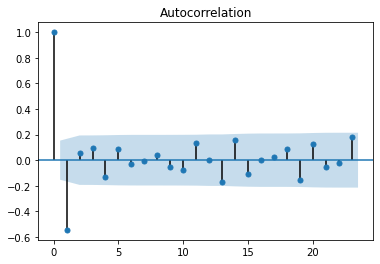

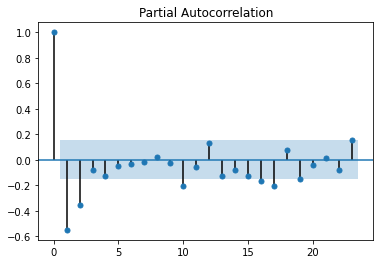

In [363]:
prueba = np.array(df_tasas_Bog['Tasa Contagios'][14:])
prueba2 = diferencia_d(df_tasas_Bog['Tasa Contagios'][14:],1)
# Identificación del parámetro AR(p) y MA(q)
plot_acf(prueba2)
plot_pacf(prueba2)
plt.show()

In [ ]:
pdq_Bog = pdq_optimos(prueba,8)

In [365]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(4,1,1))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  164
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 330.866
Method:                       css-mle   S.D. of innovations              0.032
Date:                Mon, 07 Sep 2020   AIC                           -647.731
Time:                        04:47:29   BIC                           -626.032
Sample:                             1   HQIC                          -638.922
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -2.951      0.004      -0.001      -0.000
ar.L1.D.y      0.1388      0.079      1.755      0.081      -0.016       0.294
ar.L2.D.y      0.2401      0.080      2.984      0.0

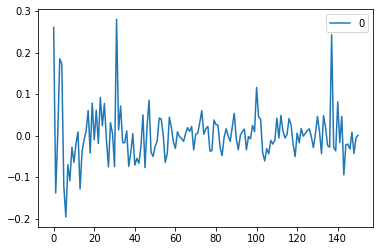

                0
count  151.000000
mean     0.001337
std      0.062142
min     -0.195760
25%     -0.029937
50%     -0.001375
75%      0.021226
max      0.280266


In [ ]:
# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-5] , prueba[-5:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=(4,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast(1)
	pred.extend(output[0].tolist())
	historia.append(test[t])
	print('predicted=%f, expected=%f' % (output[0], test[t]))

mean_squared_error(test, pred)

predicted=0.045306, expected=0.037468
predicted=0.044959, expected=0.043041
predicted=0.040021, expected=0.058121
predicted=0.044961, expected=0.056868
predicted=0.050010, expected=0.041103


0.0001227712096229698

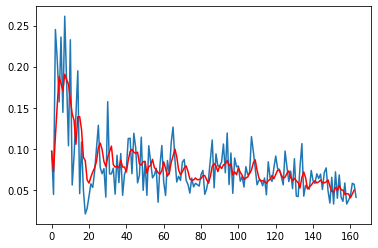

In [ ]:
plt.plot(prueba)
plt.plot(model_arima_fit.predict(typ='levels'), 'r')

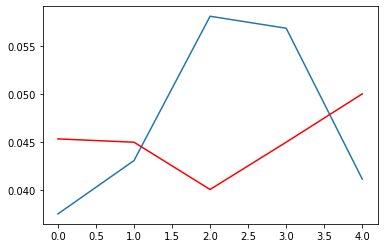

In [ ]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

##### Cali

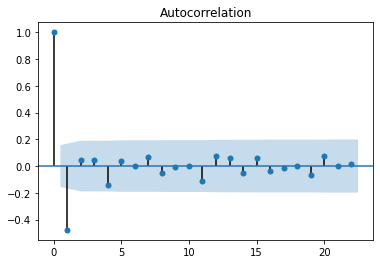

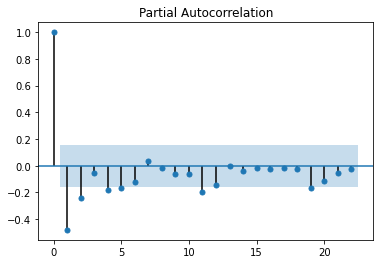

In [366]:
prueba = np.array(df_tasas_Cal['Tasa Contagios'][14:])
prueba2 = diferencia_d(df_tasas_Cal['Tasa Contagios'][14:],1)

# Identificación del parámetro AR(p) y MA(q)
plot_acf(prueba2)
plot_pacf(prueba2)
plt.show()

In [ ]:
pdq_Cal = pdq_optimos(prueba,7)

In [ ]:
pdq_Cal[0][0]

(2, 1, 3)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  151
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 208.584
Method:                       css-mle   S.D. of innovations              0.061
Date:                Sun, 06 Sep 2020   AIC                           -407.168
Time:                        05:50:34   BIC                           -392.082
Sample:                             1   HQIC                          -401.040
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -0.831      0.407      -0.003       0.001
ar.L1.D.y     -0.1816      0.149     -1.223      0.223      -0.473       0.109
ar.L2.D.y      0.0250      0.130      0.192      0.8

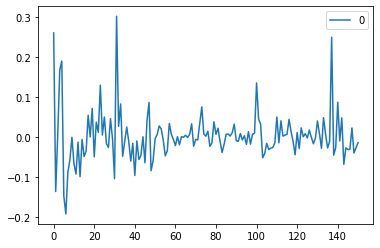

                0
count  151.000000
mean     0.001138
std      0.062763
min     -0.192406
25%     -0.026745
50%     -0.002461
75%      0.015997
max      0.302214


In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=(2,1,1))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-5] , prueba[-5:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=pdq_Cal[0][0])
	model_fit = model.fit(disp=0)
	output = model_fit.forecast(1)
	pred.extend(output[0].tolist())
	historia.append(test[t])
	print('predicted=%f, expected=%f' % (output[0], test[t]))

mean_squared_error(test, pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=0.089154, expected=0.053983
predicted=0.073126, expected=0.097561
predicted=0.074804, expected=0.032086
predicted=0.069806, expected=0.045270
predicted=0.058149, expected=0.045353


0.0008849278823156361

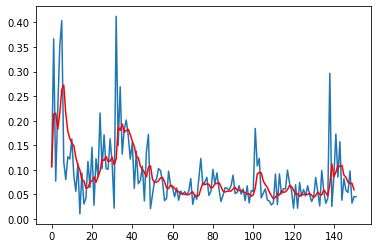

In [ ]:
plt.plot(prueba)
plt.plot(model_arima_fit.predict(typ='levels'), 'r')
plt.show()

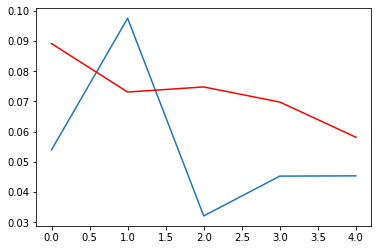

In [ ]:
plt.plot(test)
plt.plot(pred, 'r')
plt.show()

##### Cartagena

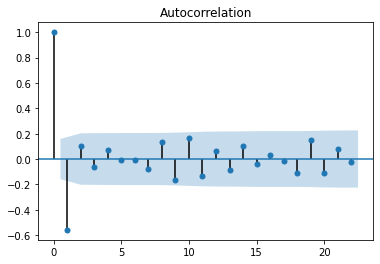

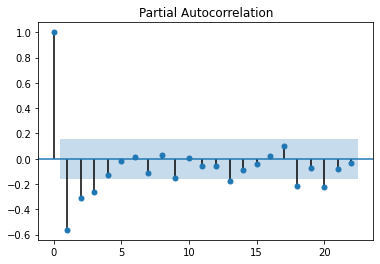

In [367]:
prueba = np.array(df_tasas_Car['Tasa Contagios'][14:])
prueba2 = diferencia_d(df_tasas_Car['Tasa Contagios'][14:],1)

# Identificación del parámetro AR(p) y MA(q)
plot_acf(prueba2)
plot_pacf(prueba2)
plt.show()

In [ ]:
pdq_Car = pdq_optimos(prueba,7)

In [ ]:
pdq_Car[0][0]

(5, 1, 3)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  151
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 215.633
Method:                       css-mle   S.D. of innovations              0.057
Date:                Sun, 06 Sep 2020   AIC                           -411.265
Time:                        04:32:27   BIC                           -381.093
Sample:                             1   HQIC                          -399.008
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.755      0.452      -0.004       0.002
ar.L1.D.y     -2.2179      0.209    -10.627      0.000      -2.627      -1.809
ar.L2.D.y     -1.9106      0.547     -3.490      0.0

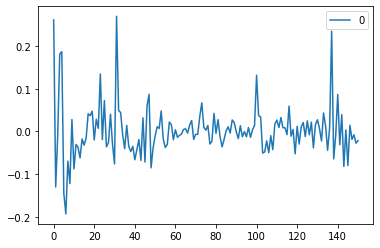

                0
count  151.000000
mean     0.001136
std      0.061170
min     -0.192711
25%     -0.029434
50%     -0.004264
75%      0.021306
max      0.269319


In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=pdq_Car[0][0])
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-5] , prueba[-5:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=pdq_Car[0][0])
	model_fit = model.fit(disp=0)
	output = model_fit.forecast(1)
	pred.extend(output[0].tolist())
	historia.append(test[t])
	print('predicted=%f, expected=%f' % (output[0], test[t]))

mean_squared_error(test, pred)

predicted=0.036569, expected=0.053983


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=0.118589, expected=0.097561
predicted=0.042077, expected=0.032086
predicted=0.073401, expected=0.045270
predicted=0.068166, expected=0.045353


0.000431403413596601

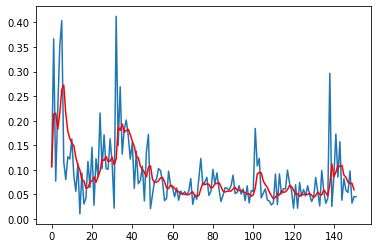

In [ ]:
plt.plot(prueba)
plt.plot(model_arima_fit.predict(typ='levels'), 'r')
plt.show()

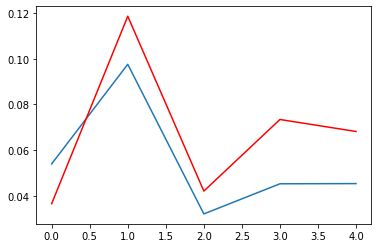

In [ ]:
plt.plot(test)
plt.plot(pred, 'r')
plt.show()

##### Medellín

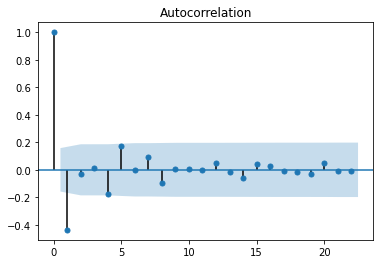

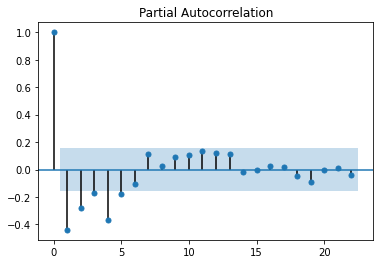

In [ ]:
prueba = np.array(df_tasas_Med['Tasa Contagios'][14:])
prueba2 = diferencia_d(df_tasas_Med['Tasa Contagios'][14:],1)
# Identificación del parámetro AR(p) y MA(q)
plot_acf(prueba2)
plot_pacf(prueba2)
plt.show()

In [ ]:
pdq_Med = pdq_optimos(prueba,7)

In [ ]:
pdq_Med[0][0]

(5, 1, 0)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  154
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 251.171
Method:                       css-mle   S.D. of innovations              0.047
Date:                Sun, 06 Sep 2020   AIC                           -488.342
Time:                        04:11:07   BIC                           -467.083
Sample:                             1   HQIC                          -479.707
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.941      0.348      -0.003       0.001
ar.L1.D.y     -0.8150      0.080    -10.217      0.000      -0.971      -0.659
ar.L2.D.y     -0.7192      0.096     -7.470      0.0

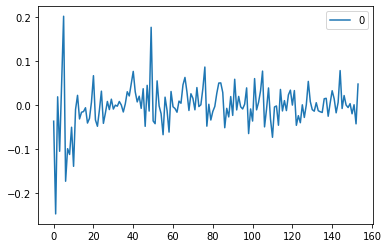

                0
count  154.000000
mean    -0.001649
std      0.048848
min     -0.246476
25%     -0.017963
50%     -0.002288
75%      0.021884
max      0.201083


In [ ]:
# Ajustando el modelo
model_arima = ARIMA(prueba, order=pdq_Med[0][0])
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

# Análisis de los residuales
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

In [ ]:
# Predicción del modelo
train, test = prueba[0:-5] , prueba[-5:]
historia = [x for x in train]
pred = list()

for t in range(len(test)):
	model = ARIMA(historia, order=pdq_Med[0][0])
	model_fit = model.fit(disp=0)
	output = model_fit.forecast(1)
	pred.extend(output[0].tolist())
	historia.append(test[t])
	print('predicted=%f, expected=%f' % (output[0], test[t]))

mean_squared_error(test, pred)

predicted=0.081498, expected=0.084671
predicted=0.077717, expected=0.057635
predicted=0.069593, expected=0.070439
predicted=0.070367, expected=0.027612
predicted=0.048565, expected=0.096745


0.0009126752707867969

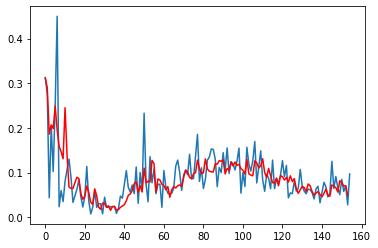

In [ ]:
plt.plot(prueba)
plt.plot(model_arima_fit.predict(typ='levels'), 'r')
plt.show()

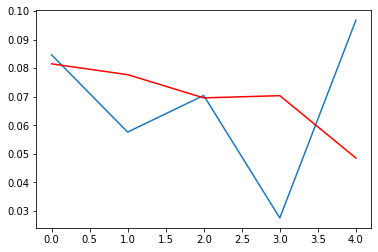

In [ ]:
plt.plot(test)
plt.plot(pred, 'r')
plt.show()

#### Aplicación

In [ ]:
# Grados p,d,q óptimos
for i in ciudades:
  print(i, globals()['pdq_'+str(i[:3])][0][0])

Barranquilla (5, 1, 4)
Bogotá D.C. (4, 1, 2)
Cali (2, 1, 3)
Cartagena de Indias (5, 1, 3)
Medellín (5, 1, 0)


In [368]:
# Grados p,d,q utilizados basados en análisis de PACF y ACF
param = { 'Bar': (5,1,1) , 'Bog': (4,1,1), 'Cal': (2,1,1), 'Car': (5,1,1),'Med': (5,1,0)}

In [435]:
# Ajuste de los modelos
# Tasas contagios, recuperados, muertes
v_tasas = ['Tasa Contagios','Tasa Recup','Tasa muertes']

dias_eliminados = 14
P = 5  # Número de registros utilizados para test

# Crear una lista de fechas para las cuales se van a generar los pronósticos
date = pd.to_datetime(cum_Med.loc[len(cum_Med)-1,['Fecha']])
Fecha = pd.date_range(start=date[0],periods=91,freq='D')[1:]

for c in ciudades:
  c = c[:3]   # Tomar iniciales de las ciudades
  # Crear dataframe para almacenar las predicciones, agregar Fechas
  globals()['pred_90_tasas' + str(c)] = pd.DataFrame(Fecha, columns=['Fecha'])

  for i in v_tasas:
    name_df = globals()['df_tasas_'+ str(c)]          # Asignar a 'name_df' el dataframe i para la ciudad c
    prueba = np.array(name_df[i][dias_eliminados:])   # Seleccionar columna de cada tasa
    train, test = prueba[:-P], prueba[-P:]            # Crear Train y Test

    # Ajuste del modelo
    globals()['model_' + str(i) + str(c)] = ARIMA(train, order=param[c])
    globals()['model_fit_' + str(i) + str(c)] = globals()['model_' + str(i) + str(c)].fit(disp=0)

    # Evaluar e imprimir residuales del modelo
    residuals = pd.DataFrame(globals()['model_fit_' + str(i) + str(c)].resid)
    print('Media de los residuales',str(i),str(c), residuals.mean()[0])
    print('DesvStd de los residuales',str(i), str(c), residuals.std()[0])

    # Predicción del modelo
    pred_aj = globals()['model_fit_' + str(i) + str(c)].predict(typ='levels')
    pred = globals()['model_fit_' + str(i) + str(c)].forecast(90+P)[0]
    name_df['Pred '+str(i)] = [None]*(param[c][1]+dias_eliminados) + pred_aj.tolist() + pred[:P].tolist()
    
    # Calcular e imprimir el error (MSE) del train y test
    print('MSE Train',str(i),str(c),mean_squared_error(pred_aj,train[param[c][1]:]))
    print('MSE Test',str(i),str(c),mean_squared_error(pred[:P],test),'\n')

    # Agregar a dataframe de predicciones cada columna (variable)
    globals()['pred_90_tasas'+ str(c)][i] = globals()['model_fit_' + str(i) + str(c)].forecast(90+P)[0][P:]

Media de los residuales Tasa Contagios Bar 0.002012060685019595
DesvStd de los residuales Tasa Contagios Bar 0.05017382045638513
MSE Train Tasa Contagios Bar 0.0025039786178120663
MSE Test Tasa Contagios Bar 0.0021667665753891995 

Media de los residuales Tasa Recup Bar 0.00043542365449836473
DesvStd de los residuales Tasa Recup Bar 0.01256220923634899
MSE Train Tasa Recup Bar 0.00015690279812269597
MSE Test Tasa Recup Bar 1.4248486978872361e-05 

Media de los residuales Tasa muertes Bar -2.889163397103958e-06
DesvStd de los residuales Tasa muertes Bar 0.004443034379292345
MSE Train Tasa muertes Bar 1.9603475658841814e-05
MSE Test Tasa muertes Bar 4.3927163382391724e-07 

Media de los residuales Tasa Contagios Bog -0.001194617253601859
DesvStd de los residuales Tasa Contagios Bog 0.03354728386297649
MSE Train Tasa Contagios Bog 0.0011197692501570264
MSE Test Tasa Contagios Bog 0.00012470258216449334 

Media de los residuales Tasa Recup Bog -0.00010723501732813415
DesvStd de los residua

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Media de los residuales Tasa muertes Cal -1.2132550249150192e-05
DesvStd de los residuales Tasa muertes Cal 0.0024846420451929054
MSE Train Tasa muertes Cal 6.132709542557388e-06
MSE Test Tasa muertes Cal 1.6726371500915757e-07 

Media de los residuales Tasa Contagios Car 0.0012782944630947647
DesvStd de los residuales Tasa Contagios Car 0.06306253387865014
MSE Train Tasa Contagios Car 0.0039514635888609154
MSE Test Tasa Contagios Car 0.0004132518614347625 

Media de los residuales Tasa Recup Car 0.0002968196844900534
DesvStd de los residuales Tasa Recup Car 0.0198297432321612
MSE Train Tasa Recup Car 0.0003906318613223979
MSE Test Tasa Recup Car 4.711223109140498e-05 

Media de los residuales Tasa muertes Car 4.691638170206848e-05
DesvStd de los residuales Tasa muertes Car 0.003800743894385036
MSE Train Tasa muertes Car 1.4349585541449909e-05
MSE Test Tasa muertes Car 1.924858225808513e-06 

Media de los residuales Tasa Contagios Med -0.0016924150463875096
DesvStd de los residuales Ta

In [436]:
pred_90_tasasMed

,Fecha,Tasa Contagios,Tasa Recup,Tasa muertes
0,2020-09-06,0.071467,0.781246,0.023299
1,2020-09-07,0.068360,0.784360,0.023421
2,2020-09-08,0.067730,0.786769,0.023536
3,2020-09-09,0.063098,0.789228,0.023665
4,2020-09-10,0.061087,0.791712,0.023796
...,...,...,...,...
85,2020-11-30,-0.007787,0.914509,0.034168
86,2020-12-01,-0.008673,0.915950,0.034296
87,2020-12-02,-0.009559,0.917392,0.034424
88,2020-12-03,-0.010445,0.918833,0.034552


### Optimización parámetro Interacción

La variable de interacción social es fundamental para replicar el comportamiento de una pandemia, este indica en promedio con cuantas personas tendrá en contacto un contagiado.

En este caso se buscará un solo parámetro promedio para cada ciudad y este será que se usará a su vez para pronosticar. Para optimizar este parámetro se usará un método que minimiza el MSE entre el número de contagios por día reales y el número de contagios por día estimados

Los **suceptibles** inciales que usa el modelo corresponden a la población total proyectada por el DANE para 2020 para cada ciudad.

In [370]:
susceptibles = {'Bogotá D.C.':7743955,'Medellín':2533424,'Barranquilla':1274250,'Cali':2252616,'Cartagena de Indias':1028736}

#### SIR Optimización

El SIR de optmización utiliza un Dataframe completo como parámetro de entrada para identificar la ciudad. Adicional a esto utiliza las tasas estimadas por los modelos ARIMA en el paso anterior.

Con este proceso se busca obtener el parametro de interacción social que minimice el MSE de los contagios por día para cada una de las ciudades.

In [427]:
def SIR_opt(df_base, interaccion=0.8):
  n=0 
  duracion_media = 14
  susceptibles = {'Bogotá D.C.':7743955,'Medellín':2533424,'Barranquilla':1274250,'Cali':2252616,'Cartagena de Indias':1028736}
  total_pob = susceptibles[c]
  df_tasas  = globals()['df_tasas_'+str(c[:3])+'_opt'] 
  #df_base = union[union['Ciudad'] == city].reset_index()
  
  
  casos_confirm = int(df_base.loc[n,['Contagios acum']])
  recuper = int(df_base.loc[n,['Recuperados']])
  muertos = int(df_base.loc[n,['Muertes']])
  suscep = total_pob - casos_confirm 
  activos = casos_confirm - recuper - muertos

  #Inicualización de listas diarias (_list) y acumulados (total_)
  total_casos_confirm = [casos_confirm]
  total_recuper = [recuper]
  total_muertos = [muertos]
  suscept_list = [suscep]
  contagios_list =[casos_confirm]
  recuperados_list = [recuper]
  muertos_list = [muertos]
  activos_list = [activos]

  for i in range(n,len(df_base)): #Todo nuestro df tiene datos
    #Actualiza variables
    tasa_contagio = float(df_tasas.loc[i,['Tasa Contagios']])
    tasa_recu = float(df_tasas.loc[i,['Tasa Recup']])
    tasa_muertes = float(df_tasas.loc[i,['Tasa muertes']])
    #interaccion = float(df_city.loc[i-1,['Tasa interacción']])
    relacion = suscep/total_pob

    contagios_dia = activos*tasa_contagio*interaccion*relacion
    recuperados_dia = activos*tasa_recu/duracion_media
    muertos_dia = activos*tasa_muertes/duracion_media

    casos_confirm += contagios_dia
    recuper += recuperados_dia
    muertos += muertos_dia
    activos = casos_confirm - recuper - muertos
    suscep = total_pob - casos_confirm
    
    #Actualiza variables díarias
    contagios_list.append(contagios_dia)
    recuperados_list.append(recuperados_dia)
    muertos_list.append(muertos_dia)
    
    #Actualiza variables acumuladas
    suscept_list.append(suscep)
    total_recuper.append(recuper)
    total_muertos.append(muertos)
    total_casos_confirm.append(casos_confirm)
    activos_list.append(activos)

  #df = pd.DataFrame(data=df_base.loc[n+10:,['Fecha']],columns=['Fecha'])
  df = pd.DataFrame()
  df['Susceptibles'] = suscept_list
  df['Casos Confirmados'] = total_casos_confirm
  df['Total Recuperados'] = total_recuper
  df['Total Muertos'] = total_muertos
  df['Contagios'] = contagios_list

  return np.array(df['Contagios'][:-1], dtype=float)

#### Conclusión de optimización

El método Curve_fit permitirá obtener el parámetro óptimo, con este se realizará el ajuste del modelo SIR para cada ciudad.

In [428]:
# 1 de la diferenciación de los modelos ARIMA y 1 calculo de la tasa con el dato anterior
len_datos = 14 + 1 + 1

# Aplicación al resto de las ciudad
for c in ciudades:
  y = union[union['Ciudad'] == c]['Contagios por dia'][len_datos:].reset_index().drop('index',axis=1)
  x = union[union['Ciudad'] == c][len_datos:].reset_index().drop('index',axis=1)
  name_df = globals()['df_tasas_'+ str(c[:3])]
  globals()['df_tasas_'+str(c[:3])+'_opt'] = name_df[len_datos-1:].reset_index().drop('index',axis=1)
  
  if (len(globals()['df_tasas_'+str(c[:3])+'_opt']) == len(y) == len(x)) == True :
    popt, pcov = curve_fit(SIR_opt, x, np.array(y).flatten())
    globals()['interaccion_popt_'+str(c[:3])] = popt[0]
    print('Parámetro óptimo de interacción ',str(c), popt[0])

Parámetro óptimo de interacción  Bogotá D.C. 0.9291864539736386
Parámetro óptimo de interacción  Medellín 0.9160650237678833
Parámetro óptimo de interacción  Barranquilla 0.8653192483914145
Parámetro óptimo de interacción  Cali 0.9139842159543023
Parámetro óptimo de interacción  Cartagena de Indias 0.801527242069967


In [415]:
interaccion_popt_Bog = 0.9291864539736386
interaccion_popt_Med = 0.9160650237678833
interaccion_popt_Bar = 0.8653192483914145
interaccion_popt_Car = 0.801527242069967
interaccion_popt_Cal = 0.9139842159543023

###SIR_ajuste

Devuelve un dataframe que muestra la evolución en el tiempo de la pandemia a partir de los estados iniciales reales, las tasas ajustadas con los modelos ARIMA de, la duración media de la enfermedad y el parámetro óptimo de interacción social.

In [402]:
import math
def SIR(city, interaccion):
  n=0 #En n+1 arranca a correr
  duracion_media = 14
  susceptibles = {'Bogotá D.C.':7743955,'Medellín':2533424,'Barranquilla':1274250,'Cali':2252616,'Cartagena de Indias':1028736}
  total_pob = susceptibles[city] 

  #df_base = union[union['Ciudad'] == city].reset_index()
  df_base = union[union['Ciudad'] == city][len_datos:].reset_index().drop('index',axis=1)
  #df_city = globals()['df_tasas_'+str(city[0:3])]
  df_city  = globals()['df_tasas_'+str(city[:3])+'_opt'].reset_index().drop('index',axis=1)

  casos_confirm = int(df_base.loc[n,['Contagios acum']])
  recuper = int(df_base.loc[n,['Recuperados']])
  muertos = int(df_base.loc[n,['Muertes']])
  suscep = total_pob - casos_confirm #susceptibles
  activos = casos_confirm - recuper - muertos

  #Inicialización de listas diarias (_list) y acumulados (total_)
  total_casos_confirm = [casos_confirm]
  total_recuper = [recuper]
  total_muertos = [muertos]
  suscept_list = [suscep]
  contagios_list =[casos_confirm]
  recuperados_list = [recuper]
  muertos_list = [muertos]
  activos_list = [activos]

  for i in range(n+1,len(df_base)): #desde el dato n+1
    
    #Actualiza variables
    tasa_contagio = float(df_city.loc[i-1,['Tasa Contagios']])
    tasa_recu = float(df_city.loc[i-1,['Tasa Recup']])
    tasa_muertes = float(df_city.loc[i-1,['Tasa muertes']])

    #tasa_contagio = float(df_city.loc[i-1,['Tasa prom cont']])
    #tasa_recu = float(df_city.loc[i-1,['Tasa prom recu']])
    #tasa_muertes = float(df_city.loc[i-1,['Tasa prom muertes']])
    #interaccion = float(df_city.loc[i-1,['Tasa interacción']])
    
    relacion = suscep/total_pob
    contagios_dia = math.ceil(activos*tasa_contagio*interaccion*relacion)
    recuperados_dia = math.ceil(activos*tasa_recu/duracion_media)
    muertos_dia = math.ceil(activos*tasa_muertes/duracion_media)
    casos_confirm = casos_confirm + contagios_dia
    recuper = recuper + recuperados_dia
    muertos = muertos + muertos_dia
    activos = casos_confirm - recuper - muertos
    suscep = total_pob - casos_confirm
    
    #Actualiza listas díarias
    contagios_list.append(contagios_dia)
    recuperados_list.append(recuperados_dia)
    muertos_list.append(muertos_dia)
    
    #Actualiza listas
    suscept_list.append(suscep)
    total_recuper.append(recuper)
    total_muertos.append(muertos)
    total_casos_confirm.append(casos_confirm)
    activos_list.append(activos)
   
  df = pd.DataFrame(data=df_base.loc[n-1:,['Fecha']],columns=['Fecha'])
  df['Susceptibles'] = suscept_list
  df['Casos Confirmados'] = total_casos_confirm
  df['Total Recuperados'] = total_recuper
  df['Total Muertos'] = total_muertos
  df['Contagios'] = contagios_list
  df['Recuperados'] = recuperados_list
  df['Muertos'] = muertos_list
  df['Activos'] = activos_list
  
  return df

In [403]:
#Para probar el ajuste del modelos se extrae el MSE para el total de contagios de la ciudad de Medellín
estimado = SIR('Medellín',interaccion_popt_Med)['Casos Confirmados'].values
real = cum_Med['Contagios'][16:].values
mse_sir = mean_squared_error(real,estimado)
print(mse_sir)

139236543.38709676


El ajuste del modelo SIR no es para nada óptimo, no obstante replica el comportamiento de la pandemia en el mediano plazo, por ende será el que se use para pronósticar en este período

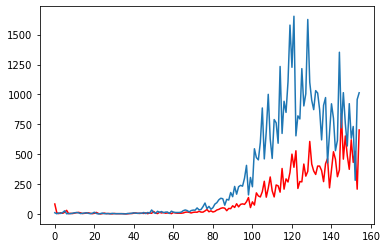

In [404]:
#SIR('Medellín',interaccion_popt_Med)['Casos Confirmados']
plt.plot(SIR('Medellín',interaccion_popt_Med)['Contagios'],'r')
plt.plot(union[union['Ciudad']=='Medellín'][len_datos:]['Contagios por dia'].reset_index().drop('index',axis=1))

###SIR pronóstico

Se pronosticaran los 90 días siguientes para cada una de las variables de la pandemia y se almacenaran en un Dataframe para luego ser ponderados con los pronósticos de los modelos autorregresivos 

In [442]:
#Se crea vector de fechas siguientes a la del último corte
fecha_pred = pd.to_datetime(union[union['Ciudad']=='Barranquilla'].reset_index().loc[len(union[union['Ciudad']=='Barranquilla'])-1,['Fecha']])
fecha_pred = pd.date_range(start=date[0],periods=91,freq='D')[1:]

In [443]:
def SIR_Pron(no_per_pron,city, interaccion):
  df_base = union[union['Ciudad'] == city].reset_index()
  df_tasas=globals()['pred_90_tasas'+ str(city[:3])]
  n = len(df_base)#En n+1 arranca a correr
  duracion_media = 14
  susceptibles = {'Bogotá D.C.':7743955,'Medellín':2533424,'Barranquilla':1274250,'Cali':2252616,'Cartagena de Indias':1028736}
  total_pob = susceptibles[city] 
  
  tasas = pd.DataFrame() #Tiene que tener una longitud = al número de periodos a pronosticar
  casos_confirm = int(df_base.loc[n-1,['Contagios acum']])
  recuper = int(df_base.loc[n-1,['Recuperados']])
  muertos = int(df_base.loc[n-1,['Muertes']])
  suscep = total_pob - int(df_base.loc[n-1,['Contagios acum']]) #susceptibles
  activos = casos_confirm - recuper - muertos
  #Deben ser en blanco para pronosticar
  suscept_list = [] 
  total_casos_confirm = []
  total_recuper = []
  total_muertos = []
  contagios_list =[]
  recuperados_list = []
  muertos_list = []
  activos_list = []


  for i in range(0,no_per_pron): #desde el dato n+1
    
    #Actualiza variables
    tasa_contagio = float(df_tasas.loc[i,['Tasa Contagios']])
    tasa_recu = float(df_tasas.loc[i,['Tasa Recup']])
    tasa_muertes = float(df_tasas.loc[i,['Tasa muertes']])
    relacion = suscep/total_pob
    
    contagios_dia = math.ceil(activos*tasa_contagio*interaccion*relacion)
    recuperados_dia = math.ceil(activos*tasa_recu/duracion_media)
    muertos_dia = math.ceil(activos*tasa_muertes/duracion_media)
    if contagios_dia < 0:
      contagios_dia = 0
    if recuperados_dia < 0:
      recuperados_dia = 0
    if muertos_dia < 0:
      muertos_dia =0
    casos_confirm = casos_confirm + contagios_dia
    recuper = recuper + recuperados_dia
    muertos = muertos + muertos_dia
    activos = casos_confirm - recuper - muertos
    suscep = total_pob - casos_confirm
    
    #Actualiza listas díarias
    contagios_list.append(contagios_dia)
    recuperados_list.append(recuperados_dia)
    muertos_list.append(muertos_dia)
    
    #Actualiza listas
    suscept_list.append(suscep)
    total_recuper.append(recuper)
    total_muertos.append(muertos)
    total_casos_confirm.append(casos_confirm)
    activos_list.append(activos)
   
  df = pd.DataFrame(data=fecha_pred,columns=['Fecha'])
  df['Susceptibles'] = suscept_list
  df['Contagios acum'] = total_casos_confirm
  df['Recuperados'] = total_recuper
  df['Muertes'] = total_muertos
  df['Contagios por dia'] = contagios_list
  df['Recuperados_dia'] = recuperados_list
  df['Muertos_dia'] = muertos_list
  df['Activos'] = activos_list
  
  return df

In [444]:
# Se genera DF de pronóstico SIR para cada ciudad 
for city in ciudades:
    globals()['df_pronSIR_'+str(city[0:3])] = SIR_Pron(90, city, globals()['interaccion_popt_'+str(city[:3])])
    globals()['df_pronSIR_'+str(city[0:3])] = globals()['df_pronSIR_'+str(city[0:3])][['Fecha','Contagios acum','Activos','Muertes','Recuperados','Contagios por dia']]
    globals()['df_pronSIR_'+str(city[0:3])]['Ciudad'] = city

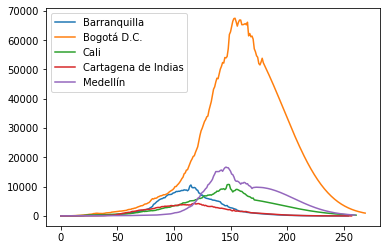

In [446]:
# Grafica del comportamiento de casos activos, uniendo datos reales con pronósticos
for city in ciudades:
  pron = SIR_Pron(90, city, globals()['interaccion_popt_'+str(city[:3])])
  
  plt.plot(np.array(union[union['Ciudad'] == city]['Activos'].reset_index().drop('index',axis=1)).flatten().tolist() + pron['Activos'].tolist())
plt.legend(ciudades)
plt.show()

La gráfica anterior muestra que el modelo prpuesto permite obtener la forma de campana característica de la pandemia para el mediano plazo.

## Pronóstico ponderado: ARIMA + SIR

In [447]:
#Se crea DF combinado para pronósticos de cada ciudad
for city in ciudades:
  globals()['pron_merge_' + str(city[0:3])] = pd.merge(globals()['pred_90_' + str(city[0:3])],globals()['df_pronSIR_'+str(city[0:3])],on=['Fecha','Ciudad'],suffixes=['_arima','_sir'])

In [448]:
# Prueba de empalme con Recuperados Medellín
r = 14
pesos = np.array( np.linspace(0,100,r).tolist() + [100 for i in range(len(pron_merge_Med)-r)])/100
pron_merge_Med['ponderado_recup'] = pron_merge_Med['Recuperados_arima']*(1-pesos) + pron_merge_Med['Recuperados_sir']*pesos

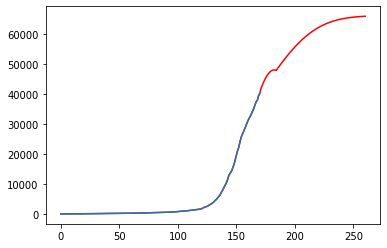

In [449]:
plt.plot(rcum_Med['Recuperados'].tolist() + pron_merge_Med['ponderado_recup'].tolist(),'r')
plt.plot(rcum_Med['Recuperados'])

In [450]:
# Crea un df unicamente con las columnas del poderado
r = 14 # parámetro de días para transferir los datos del modelo ARIMA a SIR
pesos = np.array( np.linspace(0,100,r).tolist() + [100 for i in range(len(pron_merge_Med)-r)])/100
v_columns = ['Contagios acum', 'Activos', 'Muertes', 'Recuperados', 'Contagios por dia']
pron_final = pd.DataFrame()

for city in ciudades:
  pron_df = globals()['pron_merge_' + str(city[0:3])]
  v_col = ['Fecha']
  for i in v_columns:
    pron_df[str(i)] = np.round(pron_df[str(i)+'_arima']*(1-pesos) + pron_df[str(i)+'_sir']*pesos)
    v_col.append(str(i))
  pron_df['Ciudad'] = city
  v_col.append('Ciudad')
  pron_final = pd.concat([pron_final, pron_df])

In [451]:
# Unir dataframe reales + dataframe pronosticos
df_final = pd.concat([union,pron_final[v_col]]).reset_index()

#### Gestión de Ciclo de vida del Proyecto

El modelo será revisado cada semana para validar la robustez de los parámetros autoregresivos y el empalme adecuado y suave de los modelos ARIMA y SIR.

En caso de que los resultados de las pruebas recomienden un nuevo modelo y el ajuste se deteriore en más de un 5%, se ajustará este nuevo ARIMA. También deben supervisarse las tasas estimadas para el SIR pues las medidas gubernamentales pueden tener impactos significativos y sugerir nuevos ordenes autoregresivos para sus pronósticos.

Es responsabilidad del equipo de trabajo realizar está tarea.